# Does the University of Maryland Computer Science Department need more faculty?
## An analysis by Willy Lang and Seth Rabin
#### Published December 16th, 2017
#### Last updated February 11th, 2019

## Table of Contents:
1. Introduction
2. Data Munging
    1. Faculty count data
    2. Student population data
    3. Tuition data
3. Data Exploration and Analysis
    1. Comparing student populations vs number of faculty
    2. A hypothetical scenario
    3. Bang for you buck!
    4. How does this affect ranking?
    5. UMD Computer Science Growth Rate
    6. What does UMD need to do to keep up?
4. Conclusion

# 1. Introduction

This last semester (Fall 2017), there was a lot of concern about seats for CS classes at UMD. There were many 400 level classes that filled up almost immediately when registration started. Soon after, there were waitlists of 40-60 students in a lot of sections. Students were worried they wouldn't be able to graduate on time because they couldn't take the classes they needed for their major. This was especially problematic for those in specialized tracks as they couldn't get the classes they needed for their data science or cybersecurity track. Others were being punished for having AP credits or previous experience and getting ahead in their courses. Although they finished lower level classes already, they had fewer overall credits and had to register much later than most. Some worried they would have to take only non-CS classes for a semester just to get enough credits to register earlier next time. It was a big mess.

Petitions were signed, letters were written, complaints were heard. The department ended up opening more seats for almost every class. They even opened an entirely new class. Most people were happy. Or at least, relieved. However, this seemed like a temporary bandaid for a pretty serious issue. Class sizes are really high, especially for the upper level classes. Our student body is still larger than ever, and growing. 

We wanted to see if the CS department really does have a shortage of professors, so we decided to compare our school's departments to other top schools around the country. We're going to start by collecting data on all the schools we want to look at.

This project was started as a course project for John Dickerson's CMSC320 course.

# 2. Data munging
## 2.A Faculty count data

The first step in our process will be to scour the web in search for the relevant data. We are going to be looking at the top 20 schools from CSRankings.com, as well as their rankings from US News World and Report. Thankfully, csrankings also has a list of tenured and tenure track professors and their institutions up for open access on their website. We will be using this to get professor counts for each school.

In [13]:
import pandas as pd
import numpy as np

url1 = "https://raw.githubusercontent.com/emeryberger/CSrankings/gh-pages/csrankings.csv"
professors = pd.read_csv(url1)

### Entity Resolution

Often times, data contains duplicate entries. This can occur because of a number of different reasons. It may be the case that certain entries vary slightly, but actually represent the same entity, so a simple single value check will not always catch all duplicates. As such, it is important to be thorough by checking all attributes, and coming up with a good metric for determining whether entities are the same.

That said, let's examine our data to see if there are any duplicates.

In [14]:
# confirming that there are duplicate entries in the csv based on the number of scholar IDs vs the number of
# unique scholar IDs
print(len(professors[professors["scholarid"] != 'NOSCHOLARPAGE']["scholarid"]))
print(len(professors[professors["scholarid"] != 'NOSCHOLARPAGE']["scholarid"].unique()))

12829
11029


In [15]:
# splitting the professor tables based on whether or  not they have a scholar ID
no_schol_page_profs = professors[professors["scholarid"] == "NOSCHOLARPAGE"] 
schol_page_profs = professors[professors["scholarid"] != "NOSCHOLARPAGE"]
# dropping the rows which have duplicate scholar IDs
unique_professors1 = schol_page_profs.drop_duplicates(['scholarid'])
# confirming that the number of rows is equal to the number of unique scholar IDs
print(len(unique_professors1["scholarid"]))
print(len(unique_professors1["scholarid"].unique()))

11029
11029


In [16]:
# merging the unique scholar ID dataframe with the no scholar ID dataframe because
# there could be duplicate professors who have NOSCHALARPAGE for one entry, but have their ID present in another
unique_professors2 = pd.concat([unique_professors1, no_schol_page_profs])
professors = unique_professors2.drop_duplicates(['homepage']).copy()
print(len(professors["homepage"]))
print(len(professors["homepage"].unique()))

14118
14118


Now I think we can say with relative confidence that there is not a significant number of duplicates in our data. That's great, because it means we can move on to counting the number of facuty for each school.

### Faculty count and rank for each of the top 20 schools

Because csrankings.com is dynamically generated, we just copy and pasted their data into a csv file. We use the 2007-2017 data from csrankings.org, gathered on December 15th, 2017.

In [17]:
top_20 = pd.read_csv("top.csv", delimiter="\t")
top_20

,Rank,Institution,Count,Faculty
0,1,► Carnegie Mellon University ◕,18.1,150
1,2,► Massachusetts Institute of Technology ◕,12.3,80
2,3,► Stanford University ◕,10.9,54
3,3,► University of California - Berkeley ◕,10.9,81
4,5,► University of Illinois at Urbana-Champaign ◕,10.0,85
5,6,► Cornell University ◕,8.8,67
6,7,► University of Michigan ◕,8.5,63
7,8,► University of Washington ◕,8.3,56
8,9,► University of California - San Diego ◕,6.9,53
9,10,► Georgia Institute of Technology ◕,6.8,74


In [18]:
# renaming column to get rid of whitespace in column name
top_20.rename(columns={"Institution  ":"Institution"}, inplace=True)  
# removing the icons and extra whitespace
top_20["Institution"] = top_20["Institution"].apply(lambda x : x[2:-2])  

top_20_institutions = list(top_20['Institution'])
# renaming Urbana entries so the they have the same names in both dataframs
professors.replace(to_replace="Univ. of Illinois at Urbana-Champaign", 
                   value="University of Illinois at Urbana-Champaign", inplace=True)
# creating a dataframe by grouping the professors by their affliations and counting the number at each institution
grouped = professors[professors["affiliation"].isin(top_20_institutions)].groupby("affiliation").count()
grouped

,name,homepage,scholarid
affiliation,,,
Carnegie Mellon University,173,173,173
Columbia University,53,53,53
Cornell University,82,82,82
Georgia Institute of Technology,107,107,107
Massachusetts Institute of Technology,110,110,110
Northeastern University,71,71,71
Princeton University,57,57,57
Purdue University,71,71,71
Stanford University,67,67,67


## 2.B Student population data
### Data Collection
It was actually pretty difficult to find some of the schools' CS undergraduate populations. Not all of the data was on the web, and some of it was outdated, so instead of scraping data off websites, we just searched for and asked departments for their population sizes. We compiled a csv which we will link to and read in from. The csv contains our sources as well, if you want to reproduce our results.

In [19]:
pops = pd.read_csv("undergraduate_populations_top_20.csv")
pops

,Institution,Number of Undergraduates,Source,Notes,Date
0,Massachusetts Institute of Technology,1348,http://web.mit.edu/registrar/stats/yrpts/index...,NaN,Fall 2017
1,University of Washington,819,https://studentdata.washington.edu/quick-stats/,NaN,Fall 2017
2,University of Maryland - College Park,3109,https://public.tableau.com/shared/RJ346YP5Z?:d...,NaN,Fall 2017
3,Stanford University,663,https://registrar.stanford.edu/everyone/enroll...,NaN,Spring 2017
4,University of California - Berkeley,2857,Private correspondence,NaN,Fall 2017
5,University of Illinois at Urbana-Champaign,1787,https://cs.illinois.edu/about-us/statistics,NaN,Fall 2017
6,Georgia Institute of Technology,2110,http://www.irp.gatech.edu/enrollment,NaN,Fall 2017
7,Northeastern University,1491,Private correspondence,Recieved an email from n.bekerian@northeastern...,Fall 2017
8,Cornell University,858,https://www.engineering.cornell.edu/sites/defa...,NaN,Fall 2017
9,University of Michigan,1039,https://www.eecs.umich.edu/eecs/undergraduate/...,NaN,Fall 2017


In [20]:
# Our data is split up into a bunch of different dataframes.
# We want to merge them into one useful dataframe for data analysis.

pops = pops[["Institution", "Number of Undergraduates"]]
# joining with faculty count dataframe on institution name
top_20 = top_20.join(grouped, on="Institution") 
# joining with undergrad population dataframe on institution name
top_20 = top_20.merge(pops, on="Institution")  
# both of these operations added the columns from the grouped and pops dataframes which had a corresponding
# institution in the top_20 dataframe
top_20 = top_20[["Rank  ", "Institution", "name", "Number of Undergraduates"]]
top_20.rename(columns={"Rank  ":"csankings_rank", "name":"faculty_count", "Institution":"institution",
               "Number of Undergraduates":"undergraduate_pop"}, inplace=True)

## 2.C Tuition Data
This data is readily available from each university's website. We simply googled each of the top 20 schools. We also have the US News rankings for each of these schools in this csv, since US News is one of the most popular rankings. However, they don't allow scraping (as shown here: https://www.usnews.com/robots.txt), so we entered each university's  2017 CS ranking into the csv file that we load in below.

In [21]:
tuitions = pd.read_csv('undergraduate_tuitions_top_20.csv')
tuitions
tuitions = tuitions[["Institution","Private/Public","Resident Tuition","Non-Resident Tuition",'usnews_rank']].copy()
tuitions.rename(columns={"Institution":"institution",
                         "Private/Public":"public-private", 
                         "Resident Tuition":"in_state_tuition", 
                         "Non-Resident Tuition":"out_of_state_tuition"}, inplace=True)

top_20 = top_20.merge(tuitions, on="institution")

# setting Cornell's faculty count to 36 based on pull request https://github.com/krixly/krixly.github.io/issues/2
top_20.loc[5, 'faculty_count'] = 36.0
top_20

,csankings_rank,institution,faculty_count,undergraduate_pop,public-private,in_state_tuition,out_of_state_tuition,usnews_rank
0,1,Carnegie Mellon University,173.0,719,private,52732.0,52732.0,22.0
1,2,Massachusetts Institute of Technology,110.0,1348,private,48452.0,48452.0,4.0
2,3,Stanford University,67.0,663,private,48987.0,48987.0,6.0
3,3,University of California - Berkeley,109.0,2857,public,14068.0,42082.0,8.0
4,5,University of Illinois at Urbana-Champaign,104.0,1787,public,18370.0,34490.0,46.0
5,6,Cornell University,36.0,858,private,35483.0,52853.0,67.0
6,7,University of Michigan,81.0,1039,public,14826.0,47476.0,59.0
7,8,University of Washington,64.0,819,public,16272.0,28320.0,56.0
8,9,University of California - San Diego,75.0,1961,public,14050.0,42064.0,24.0
9,10,Georgia Institute of Technology,107.0,2110,public,10008.0,30604.0,16.0


# 3. Data Exploration and Analysis
## 3.A Comparing student populations vs number of faculty

The main problem with having so many students is that there must be a reasonable number of professors to teach them. Because of this, we are going to examine the student to faculty ratio of each school.

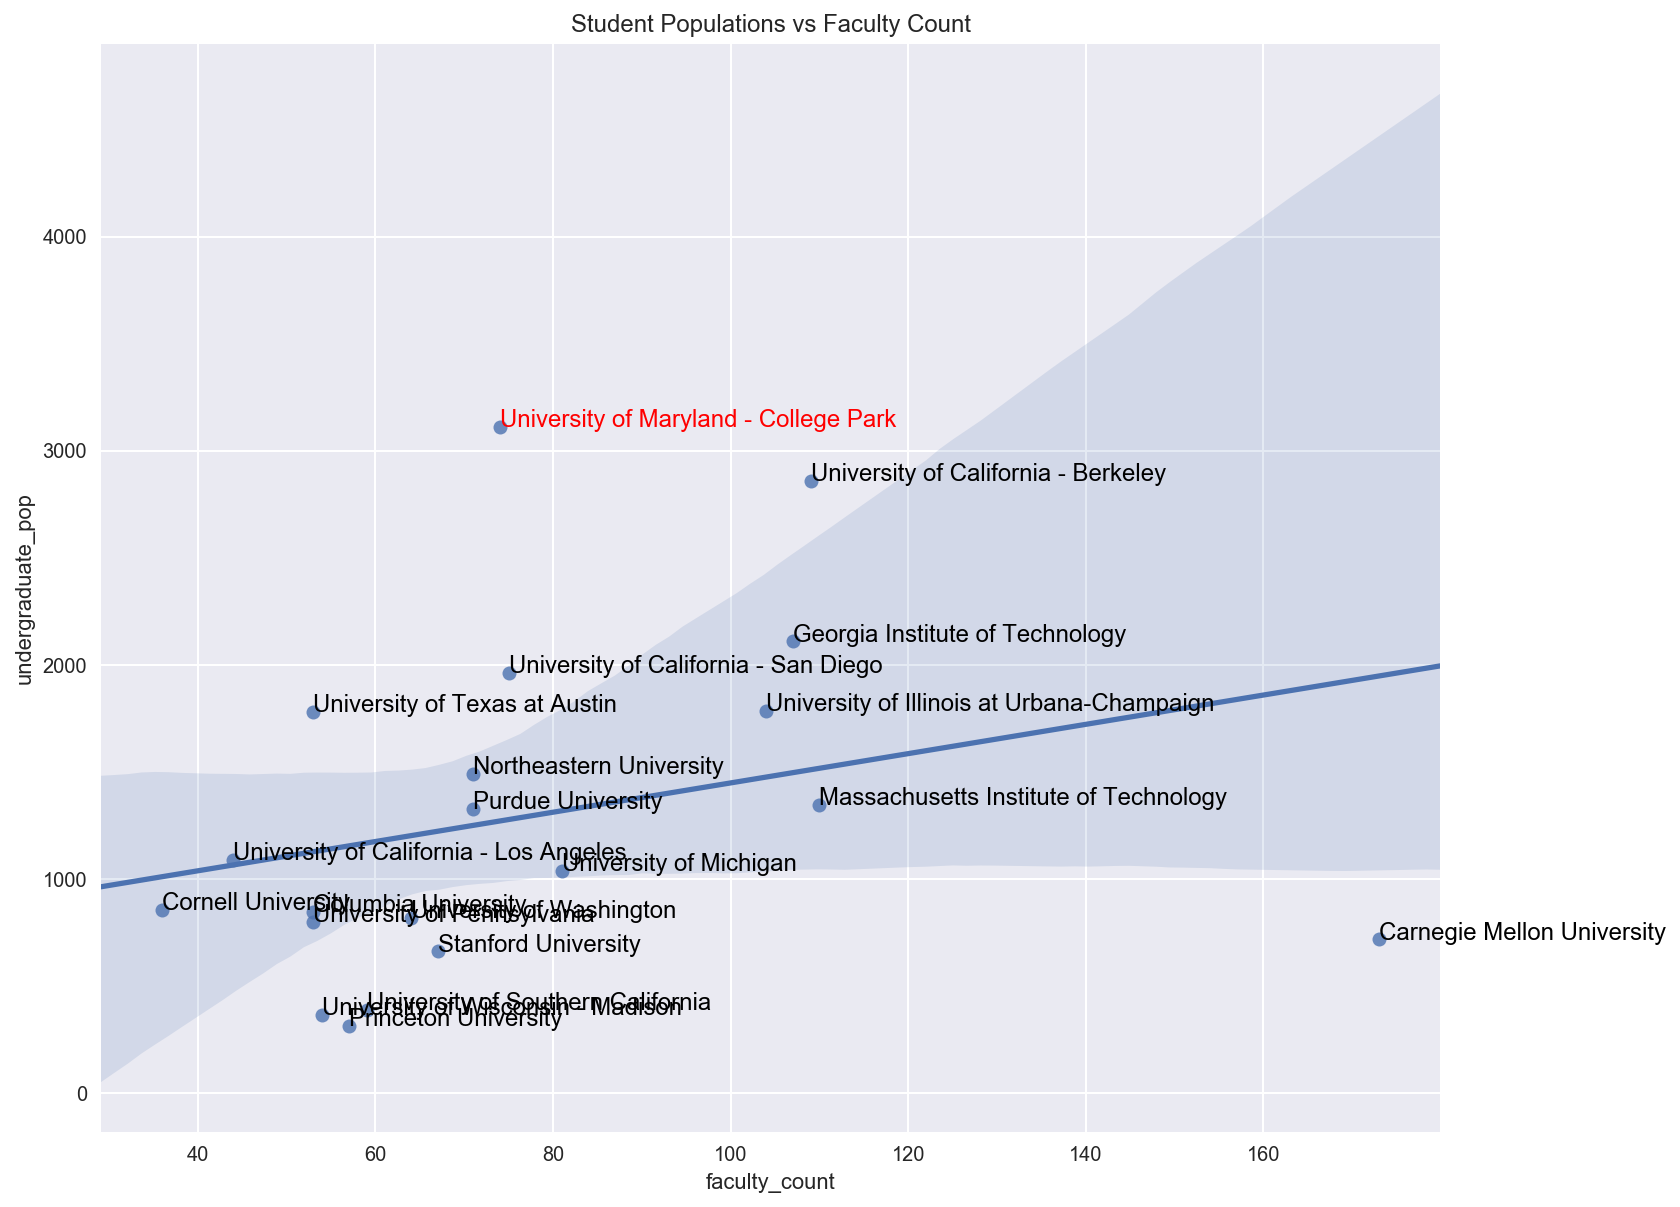

In [22]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# you can add these lines to your jupyter notebook if you don't want to use plt.show()
# everytime you want to display a plot
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# adjusting some plot display settings
matplotlib.rcParams['figure.figsize'] = [12, 10]
sns.set(color_codes=True)

def regplot_top20(df, x, y, title):
    """
    Takes in a dataframe, the name of two columns in the dataframe, and a title.
    Creates a sns regplot with labels based on institution.
    """
    fig, ax = plt.subplots()  # exposing the fig and ax here so ax can be used to label
    fig = sns.regplot(df[x], df[y], dropna=True)
    plt.title(title)
    # labeling every point and highlighting UMD
    for i, txt in enumerate(df['institution']):
        if "College Park" in txt:
            c = "red"
        else:
            c = "black"
        ax.annotate(txt, (df[x][i],df[y][i]), color=c)

# plotting student populations vs faculty count
regplot_top20(top_20, "faculty_count", "undergraduate_pop", "Student Populations vs Faculty Count")

Two pretty clear outliers here: University of Maryland- College Park and Carnegie Mellon. Berkeley looks like it's a above trend too. Let's see all the student to faculty ratios, maybe that will help us get a better idea of the situation. We are going to create a barplot and add a line for the mean ratio.

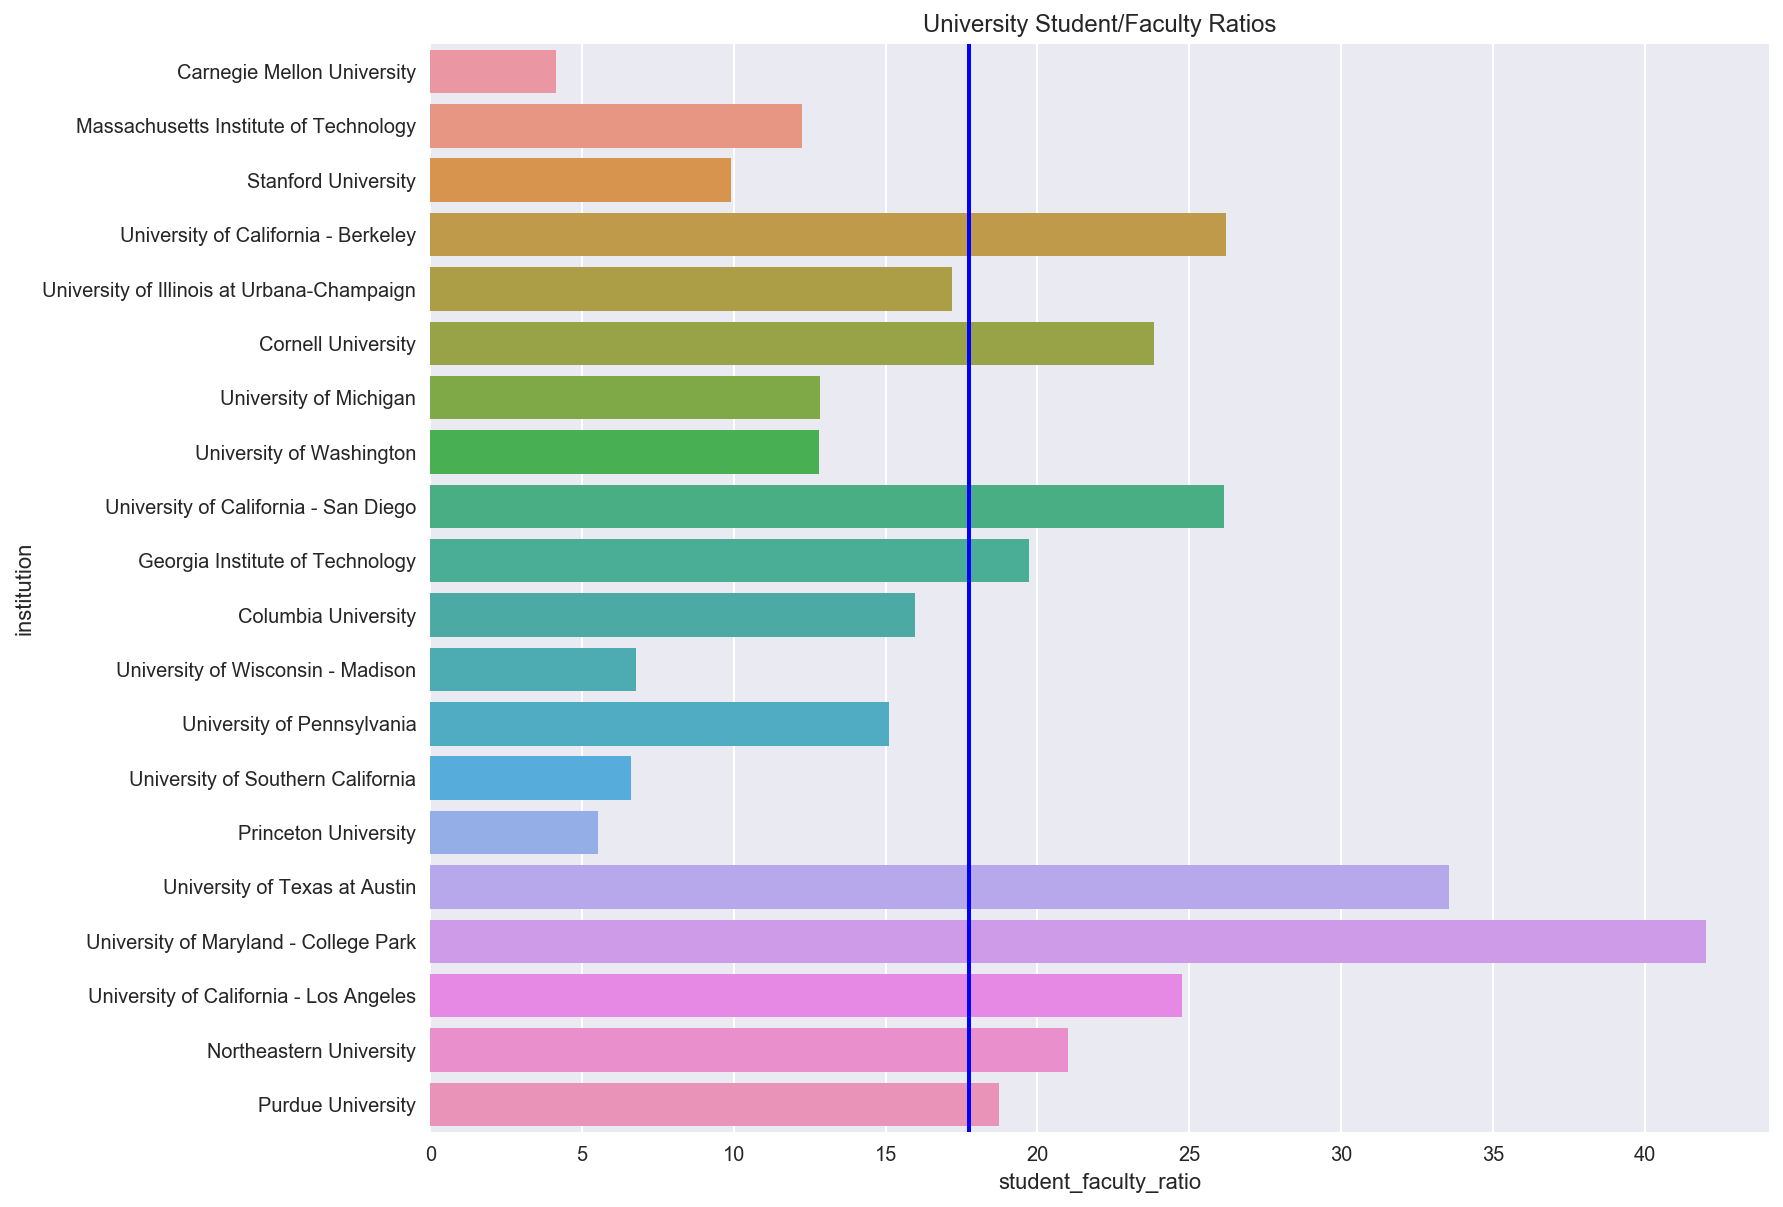

In [23]:
# calculating student/faculty ratio
top_20["student_faculty_ratio"] = top_20["undergraduate_pop"]/top_20["faculty_count"]

fig, ax = plt.subplots()
plt.title("University Student/Faculty Ratios")
fig = sns.barplot(y=top_20["institution"], x=top_20["student_faculty_ratio"])
# adding a verticle line for the mean ratio
ax.axvline(top_20["student_faculty_ratio"].mean(), color="blue", linewidth=2)

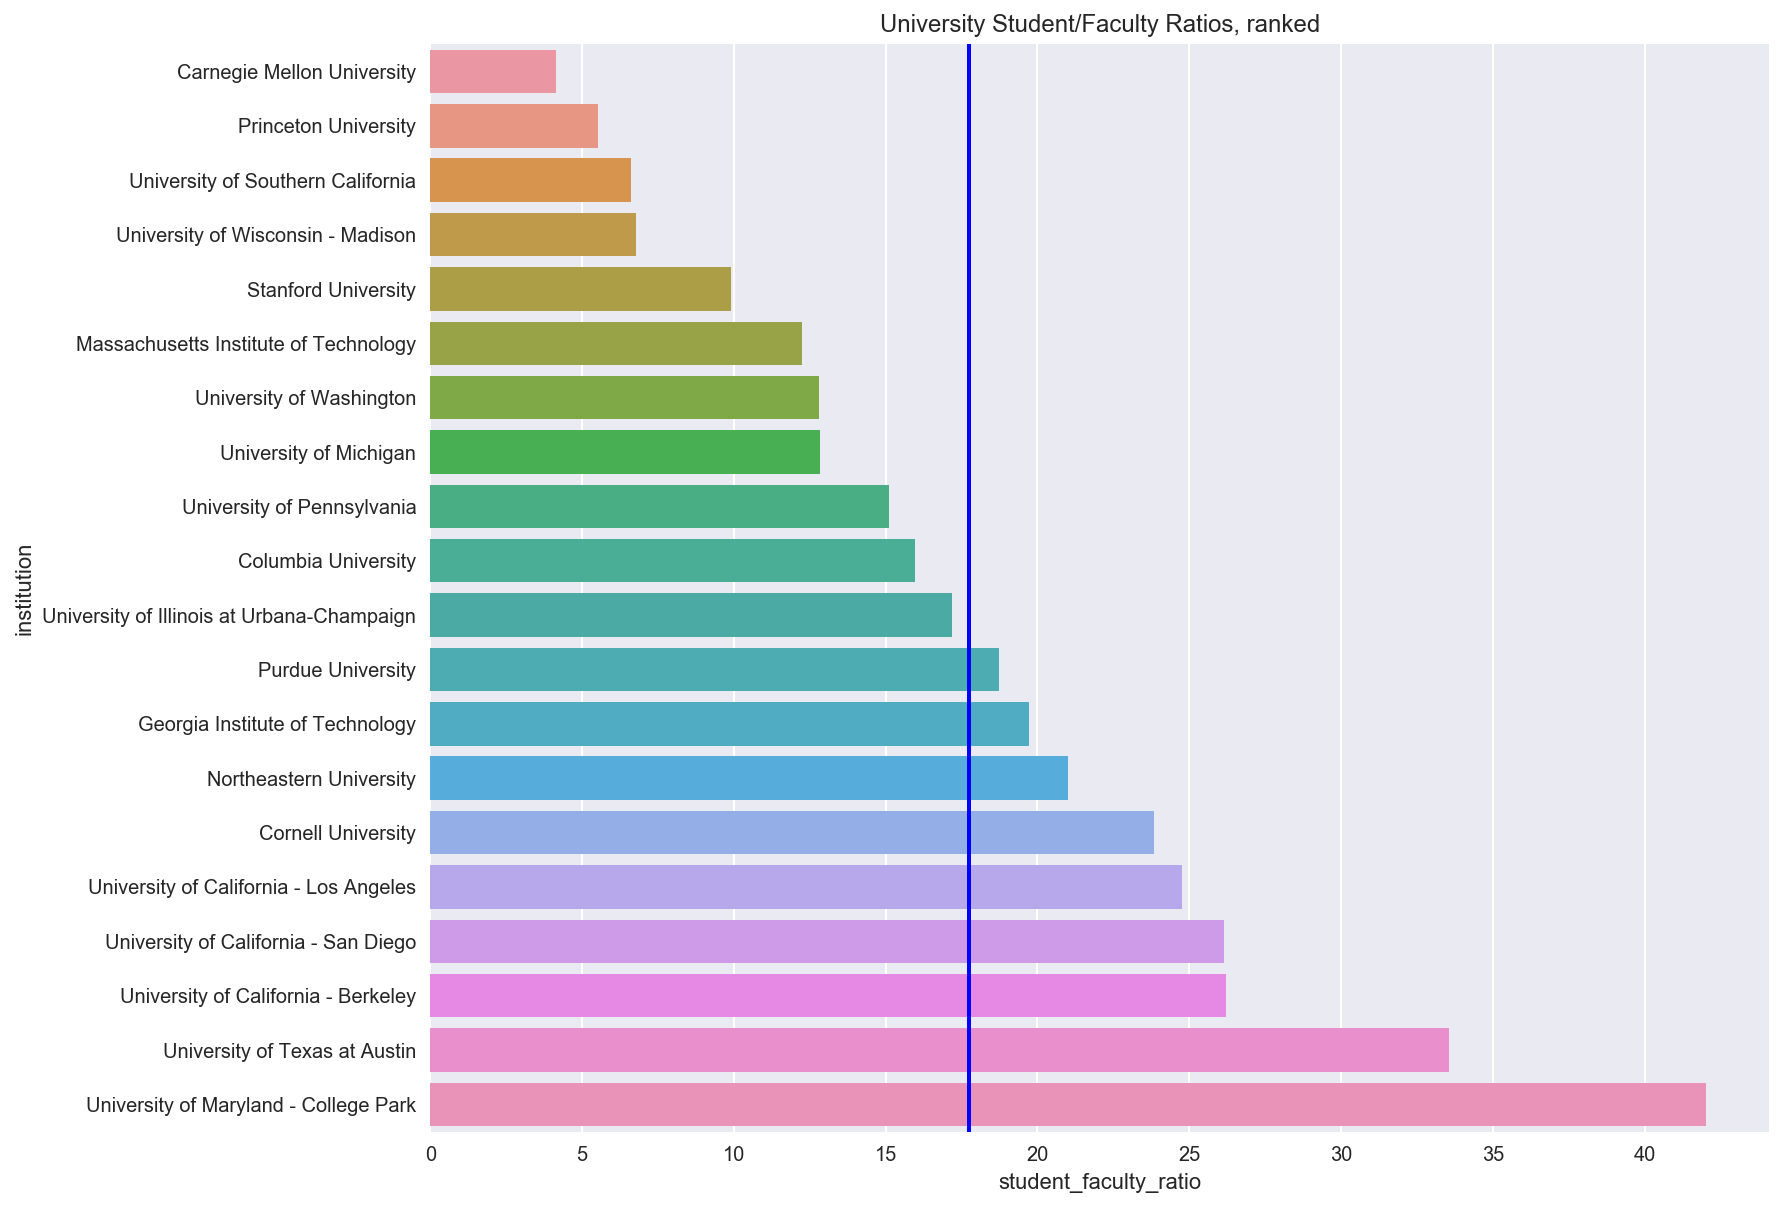

In [24]:
fig, ax = plt.subplots()
plt.title("University Student/Faculty Ratios, ranked")
order = np.argsort(top_20["student_faculty_ratio"])
fig = sns.barplot(y=top_20["institution"][order], x=top_20["student_faculty_ratio"][order])
ax.axvline(top_20["student_faculty_ratio"].mean(), color="blue", linewidth=2)

UMD appears to have almost 2.5x the average amount of students per faculty! It also looks like the highest rank ones (remember, the schools are sorted by their csranking rank in the first graph above) also happen to have lower student/faculty ratios, while the lower five are all above the mean.

## 3.B A hypothetical scenario
We know our student population data can be a bit iffy. Some of it was from a semester back because schools didn't have newer data. Some schools are also known to have some policies which will distort major count, such as not letting people declare their majors until spring semester or their sophomore year. 

Because of this, we're going to make the (almost certainly massive) overestimation that every school besides UMD
actually has 1.5 times as many total students as they say. We will look at the same charts with this hypothetical data.

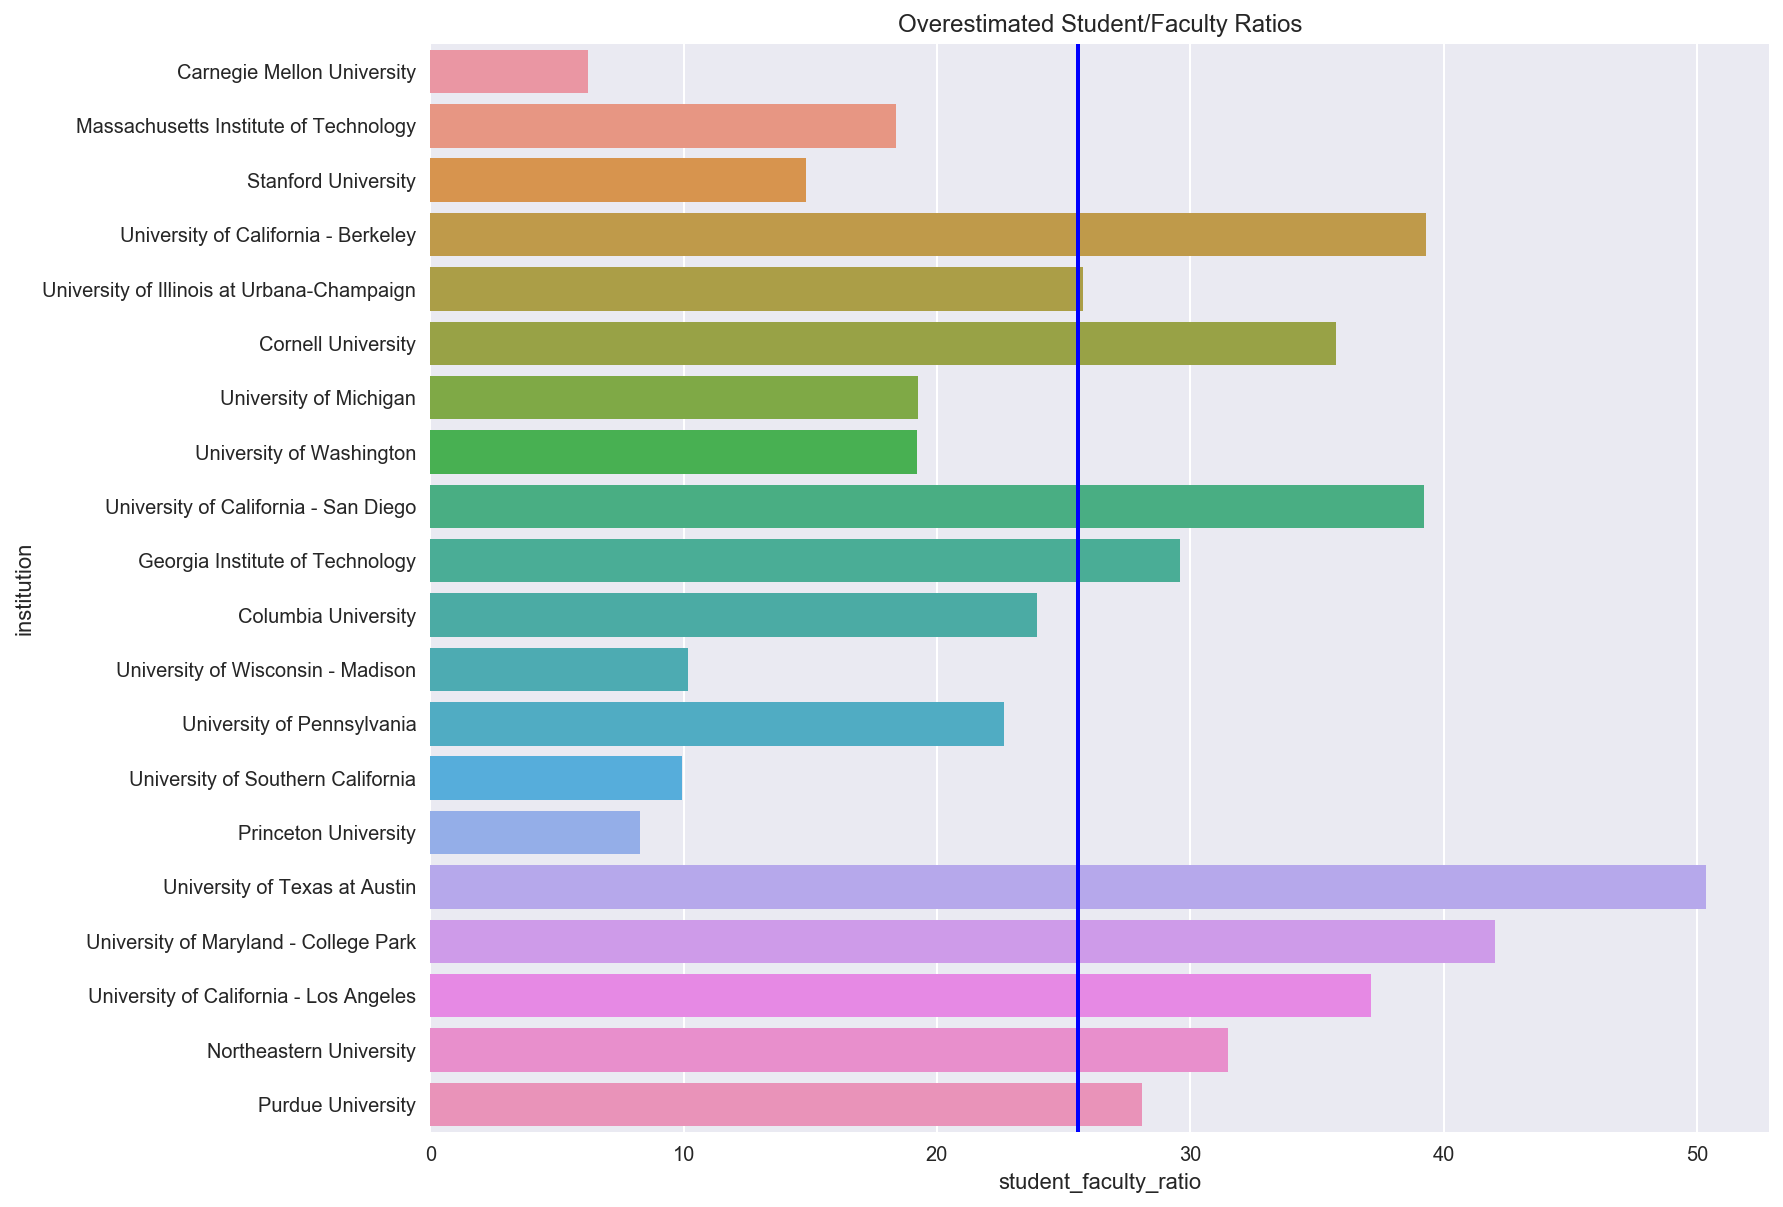

In [25]:
top_20_hypothetical = top_20.copy()
# multiplying the population counts by 1.5
top_20_hypothetical["new_count"] = top_20_hypothetical["undergraduate_pop"]*1.5
# replacing UMD's new count with the old count
top_20_hypothetical["new_count"].replace(to_replace=4663.5, value = 3109, inplace=True)
# calculating student/faculty ratio
top_20_hypothetical["student_faculty_ratio"] = top_20_hypothetical["new_count"]/top_20_hypothetical["faculty_count"]
fig, ax = plt.subplots()
plt.title("Overestimated Student/Faculty Ratios")
fig = sns.barplot(y=top_20_hypothetical["institution"], x=top_20_hypothetical["student_faculty_ratio"])
# adding a verticle line for the mean ratio
ax.axvline(top_20_hypothetical["student_faculty_ratio"].mean(), color="blue", linewidth=2)

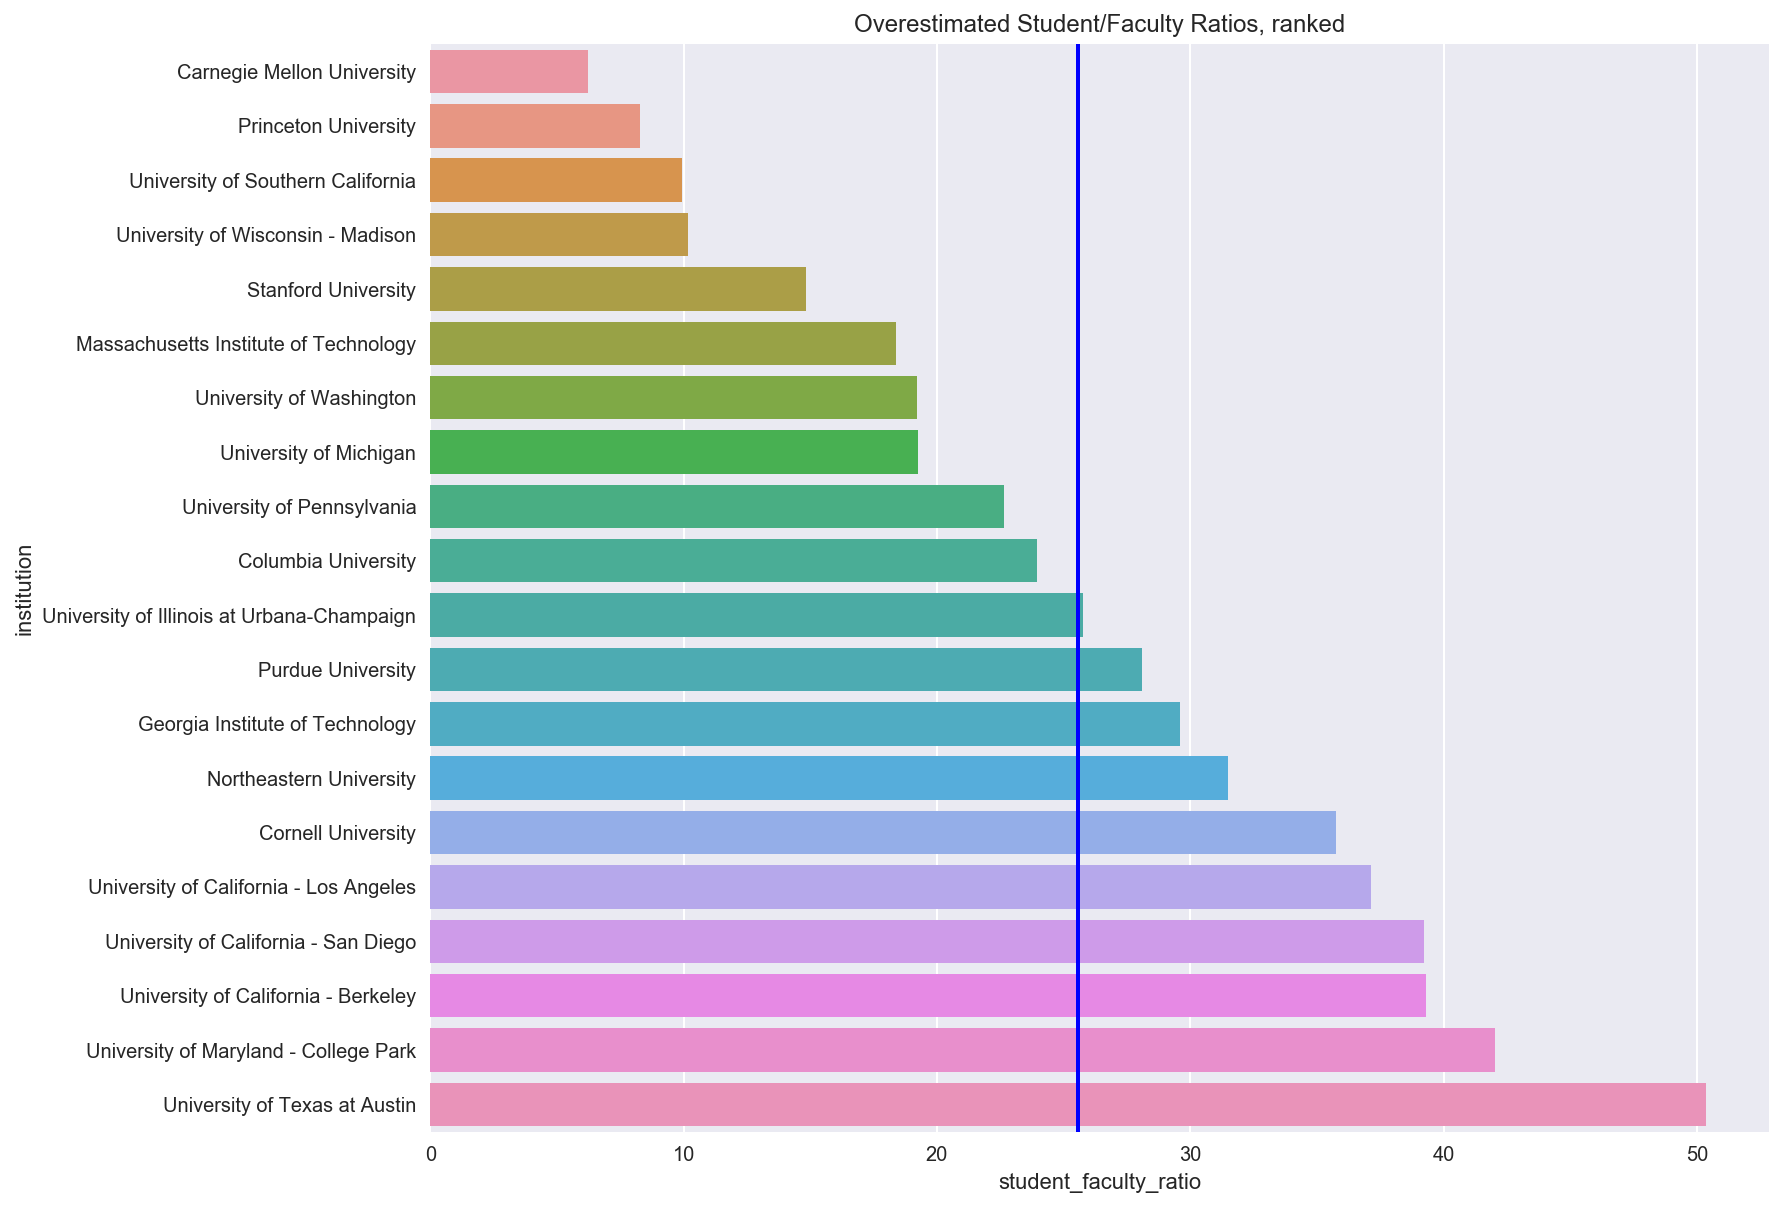

In [26]:
fig, ax = plt.subplots()
plt.title("Overestimated Student/Faculty Ratios, ranked")
order = np.argsort(top_20_hypothetical["student_faculty_ratio"])
fig = sns.barplot(y=top_20_hypothetical["institution"][order], x=top_20_hypothetical["student_faculty_ratio"][order])
# adding a verticle line for the mean ratio
ax.axvline(top_20_hypothetical["student_faculty_ratio"].mean(), color="blue", linewidth=2)

Well, it looks like UMD is still the highest, even with this massive overestimation for the other schools. UMD is still double the average! Let's show the scatter plot with the overestimated data so we can how much of an outlier we still are.

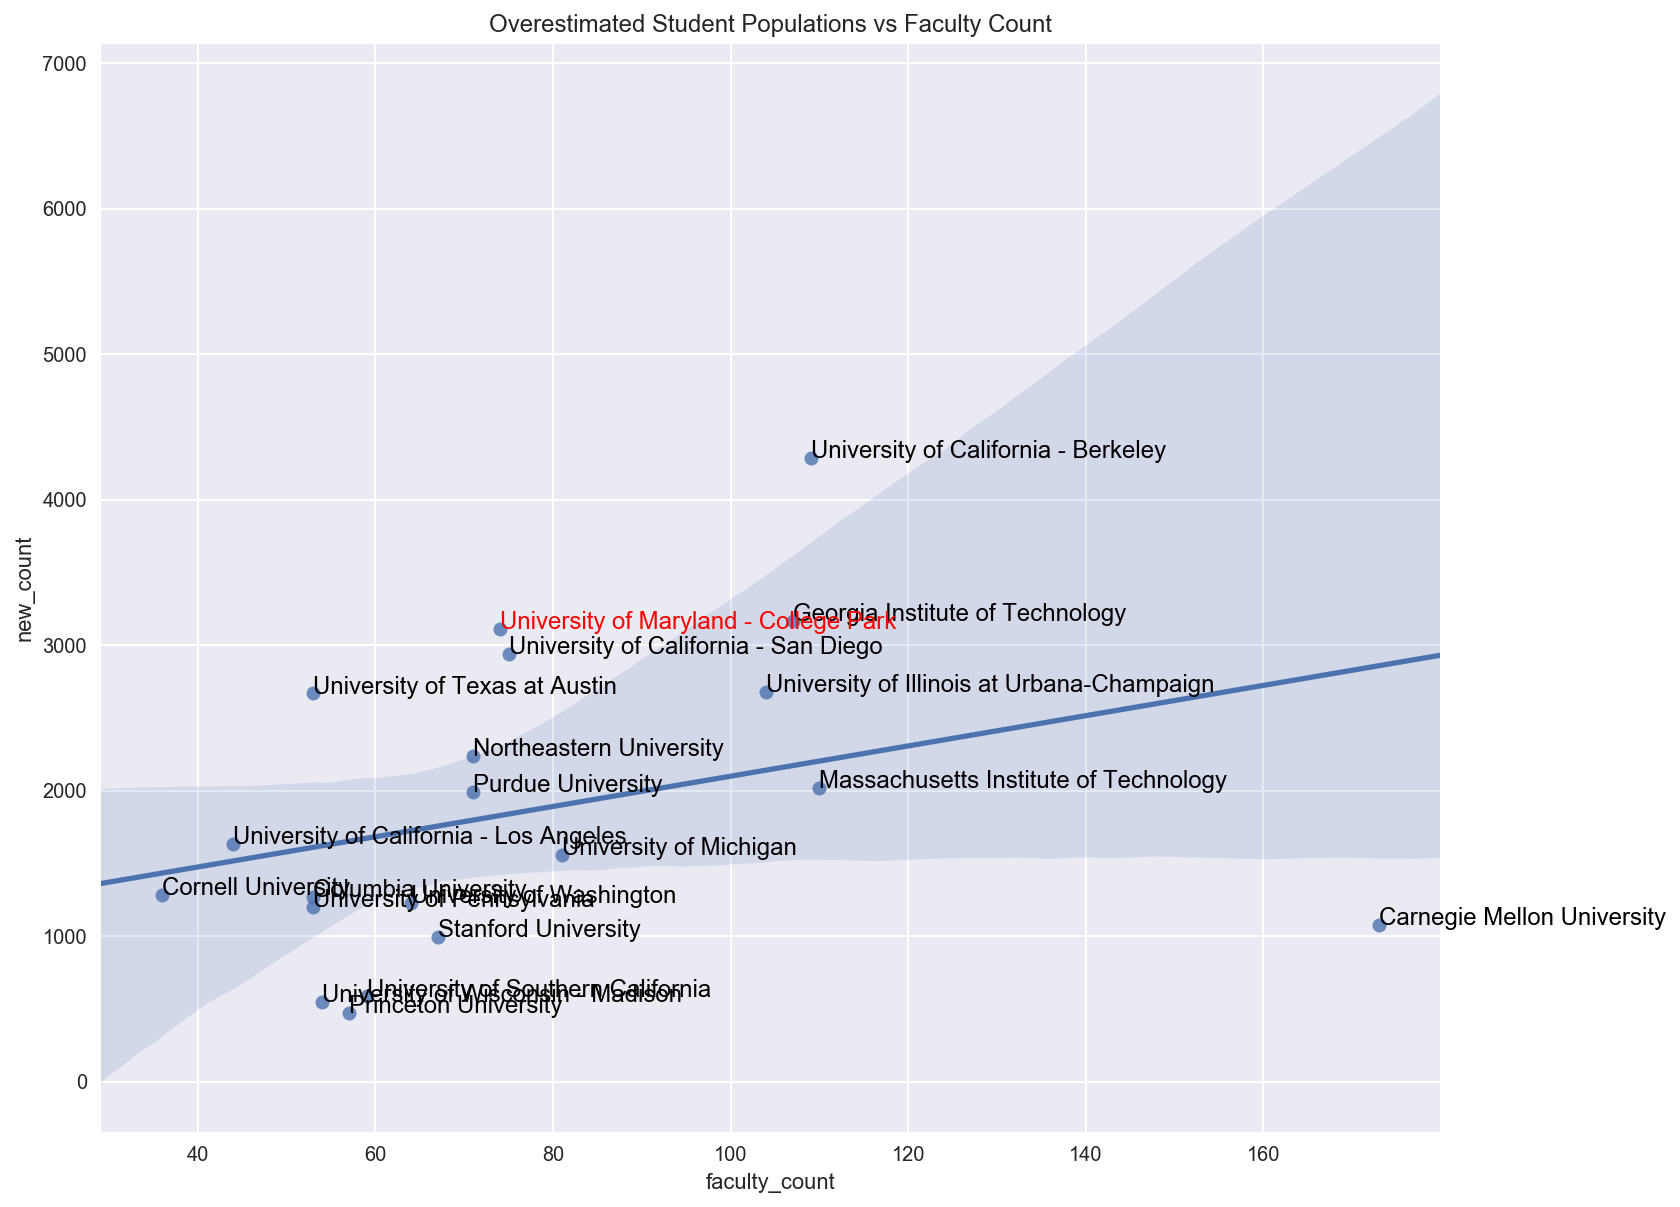

In [27]:
# plotting faculty count vs undergraduate population
regplot_top20(top_20_hypothetical, "faculty_count", "new_count", 
              "Overestimated Student Populations vs Faculty Count")

UMD is a lot less of an outlier now, but that's only with an overestimate for every other school's CS population besides ours. So not exactly a plus.

Seeing how high UMD's student/faculty ratio is, it would be interesting to see if students are at least getting a good bang for their buck when it comes to faculty attention. 

## 3.C Bang for your buck!
We want to somehow measure how far your money goes in terms of how many professors (or how much of a professor) you get per 10000 dollars spent.

First let's see how the different schools match up with each other when we graph faculty-student ratio over tuition. This will give us an idea of how much professorness you can get for different costs.
Note: Obviously this is a very shallow measure of overall value of a school, and that faculty-student ratio does not necessarily reflect the quality of education you would receive if you go to one of these schools. We're just going to make the assumption that each of the professors at all of these schools are equally valuable to an undergrad's education. 

We also want to see how in-state cost measures up against out-of-state costs, but private universities generally have the same out of state and in-state costs. To account for this, we input the same cost for both out-of-state and in-state for those universities that don't distinguish. Later we will explore how these different costs changes bang for your buck.

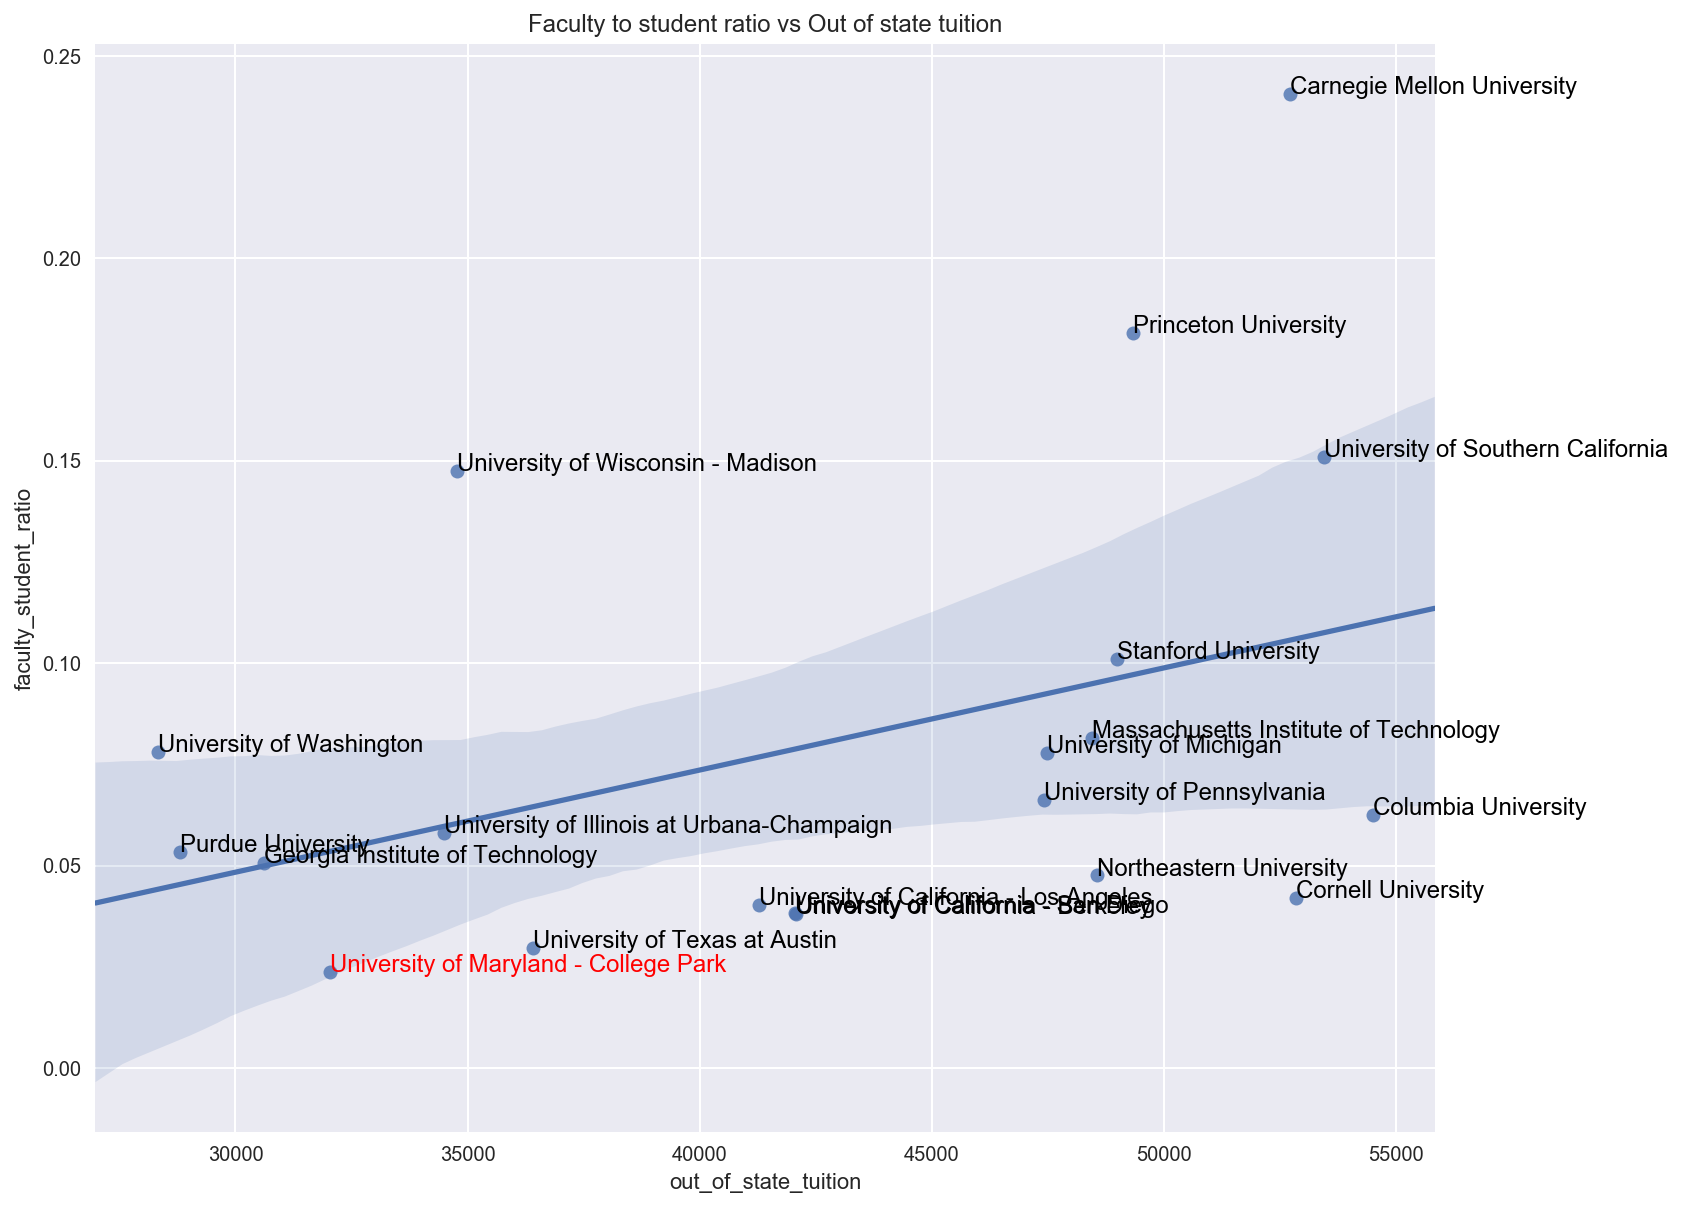

In [28]:
# calculating how much of a professor every student gets to themselves
top_20['faculty_student_ratio'] = top_20['faculty_count']/top_20['undergraduate_pop']
# plotting faculty-student ratio vs out of state tuition
regplot_top20(top_20, "out_of_state_tuition", "faculty_student_ratio",
              "Faculty to student ratio vs Out of state tuition")

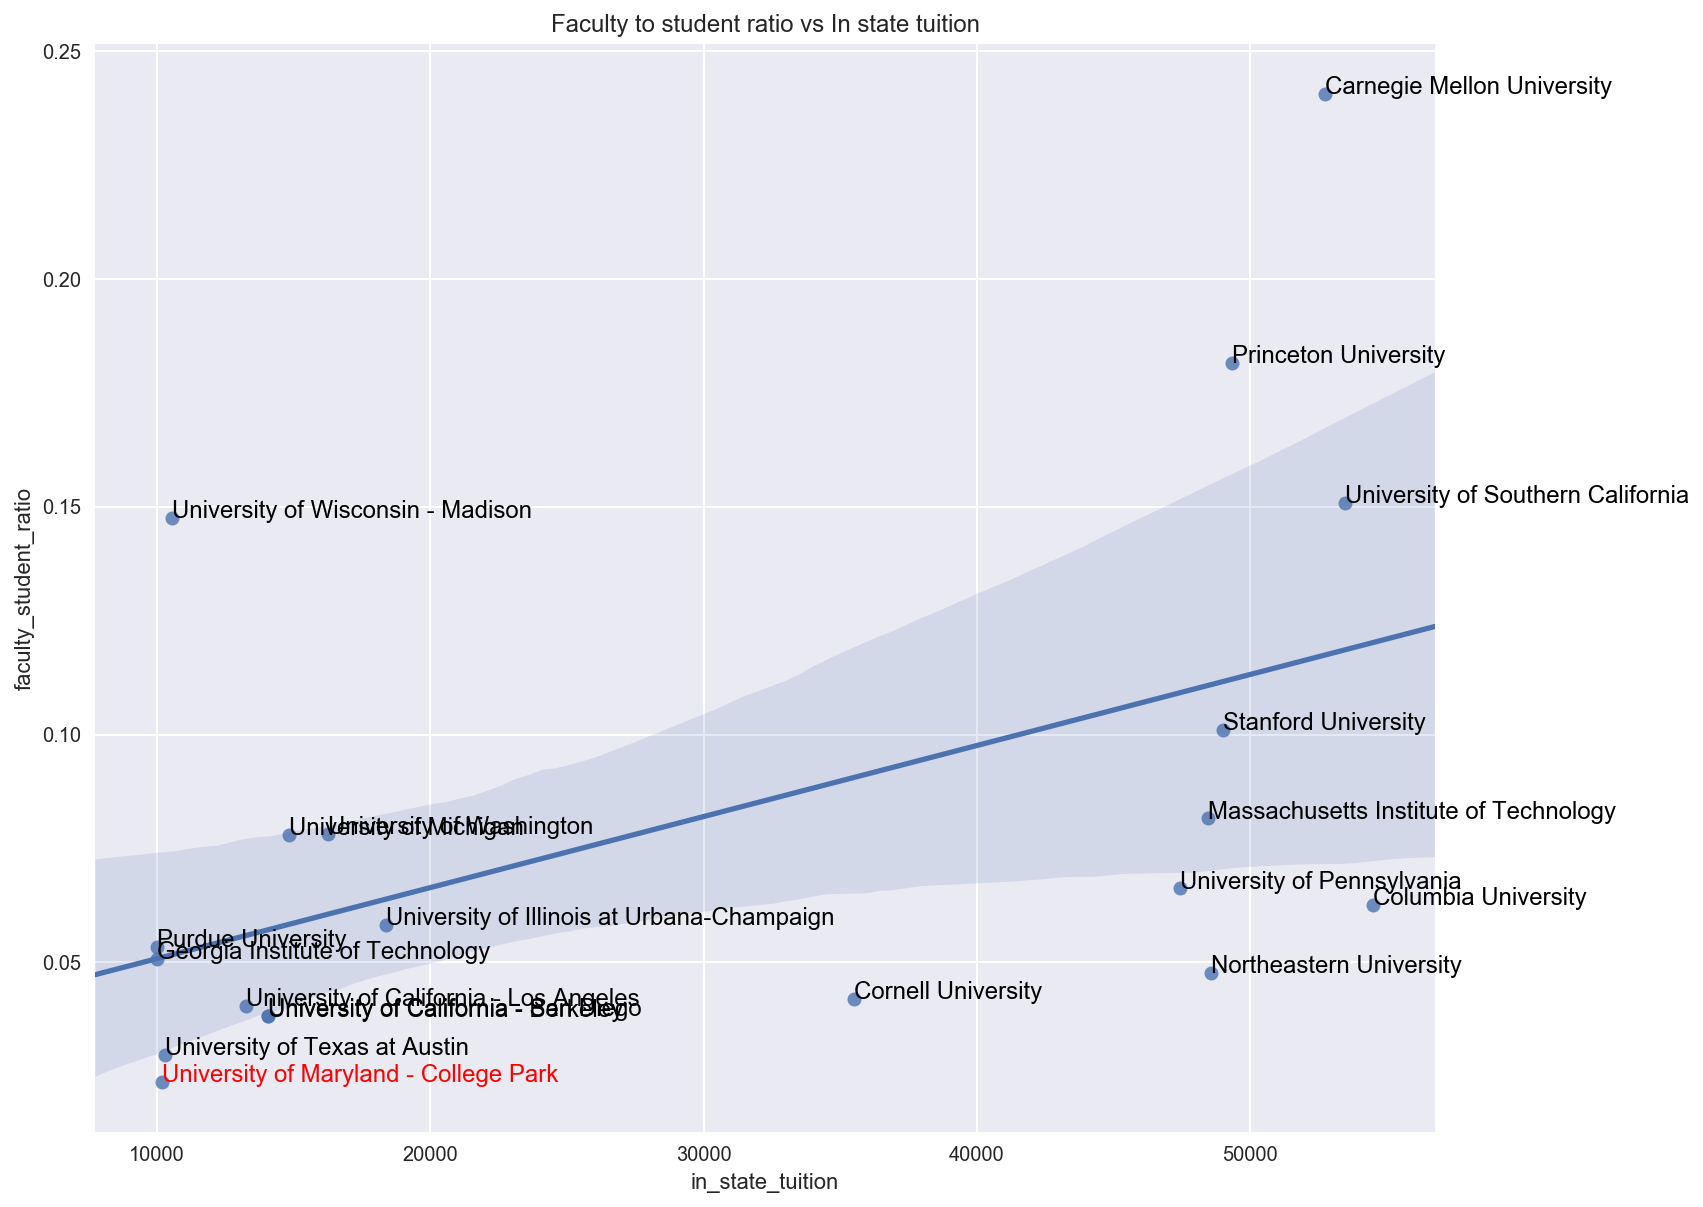

In [29]:
# plotting faculty count vs undergraduate population
regplot_top20(top_20, "in_state_tuition", "faculty_student_ratio",
              "Faculty to student ratio vs In state tuition")

It's looking better! Even though UMD's faculty to student ratio is the lowest, they are one of the lowest cost schools too. Let's see if this holds up when we calculate our "bang for buck" metric. We are going to distinguish public and private universities here, as private schools tend to have the same costs for both in-state and out of state.

In [30]:
# calculating out of state bang
top_20['bang_for_your_buck_out'] = (top_20['faculty_student_ratio']/top_20['out_of_state_tuition'])*1000
mean_out = top_20['bang_for_your_buck_out'].mean()
std_out = top_20['bang_for_your_buck_out'].std()
# normalizing our out-of-state "bang for your buck" value
top_20['normalized_bang_for_your_buck_out'] = (top_20['bang_for_your_buck_out'] - mean_out)/std_out

# calculating in state bang
top_20['bang_for_your_buck_in'] = (top_20['faculty_student_ratio']/top_20['in_state_tuition'])*1000
mean_in = top_20['bang_for_your_buck_in'].mean()
std_in = top_20['bang_for_your_buck_in'].std()
# normalizing our in-state "bang for your buck" value
top_20['normalized_bang_for_your_buck_in'] = (top_20['bang_for_your_buck_in'] - mean_in)/std_in

# sorting the schools by whether they are public or private
top_20_sorted_private_public = top_20.sort_values('public-private')

Text(0.5,1,'Bang for Your Buck (Out-of-State)')

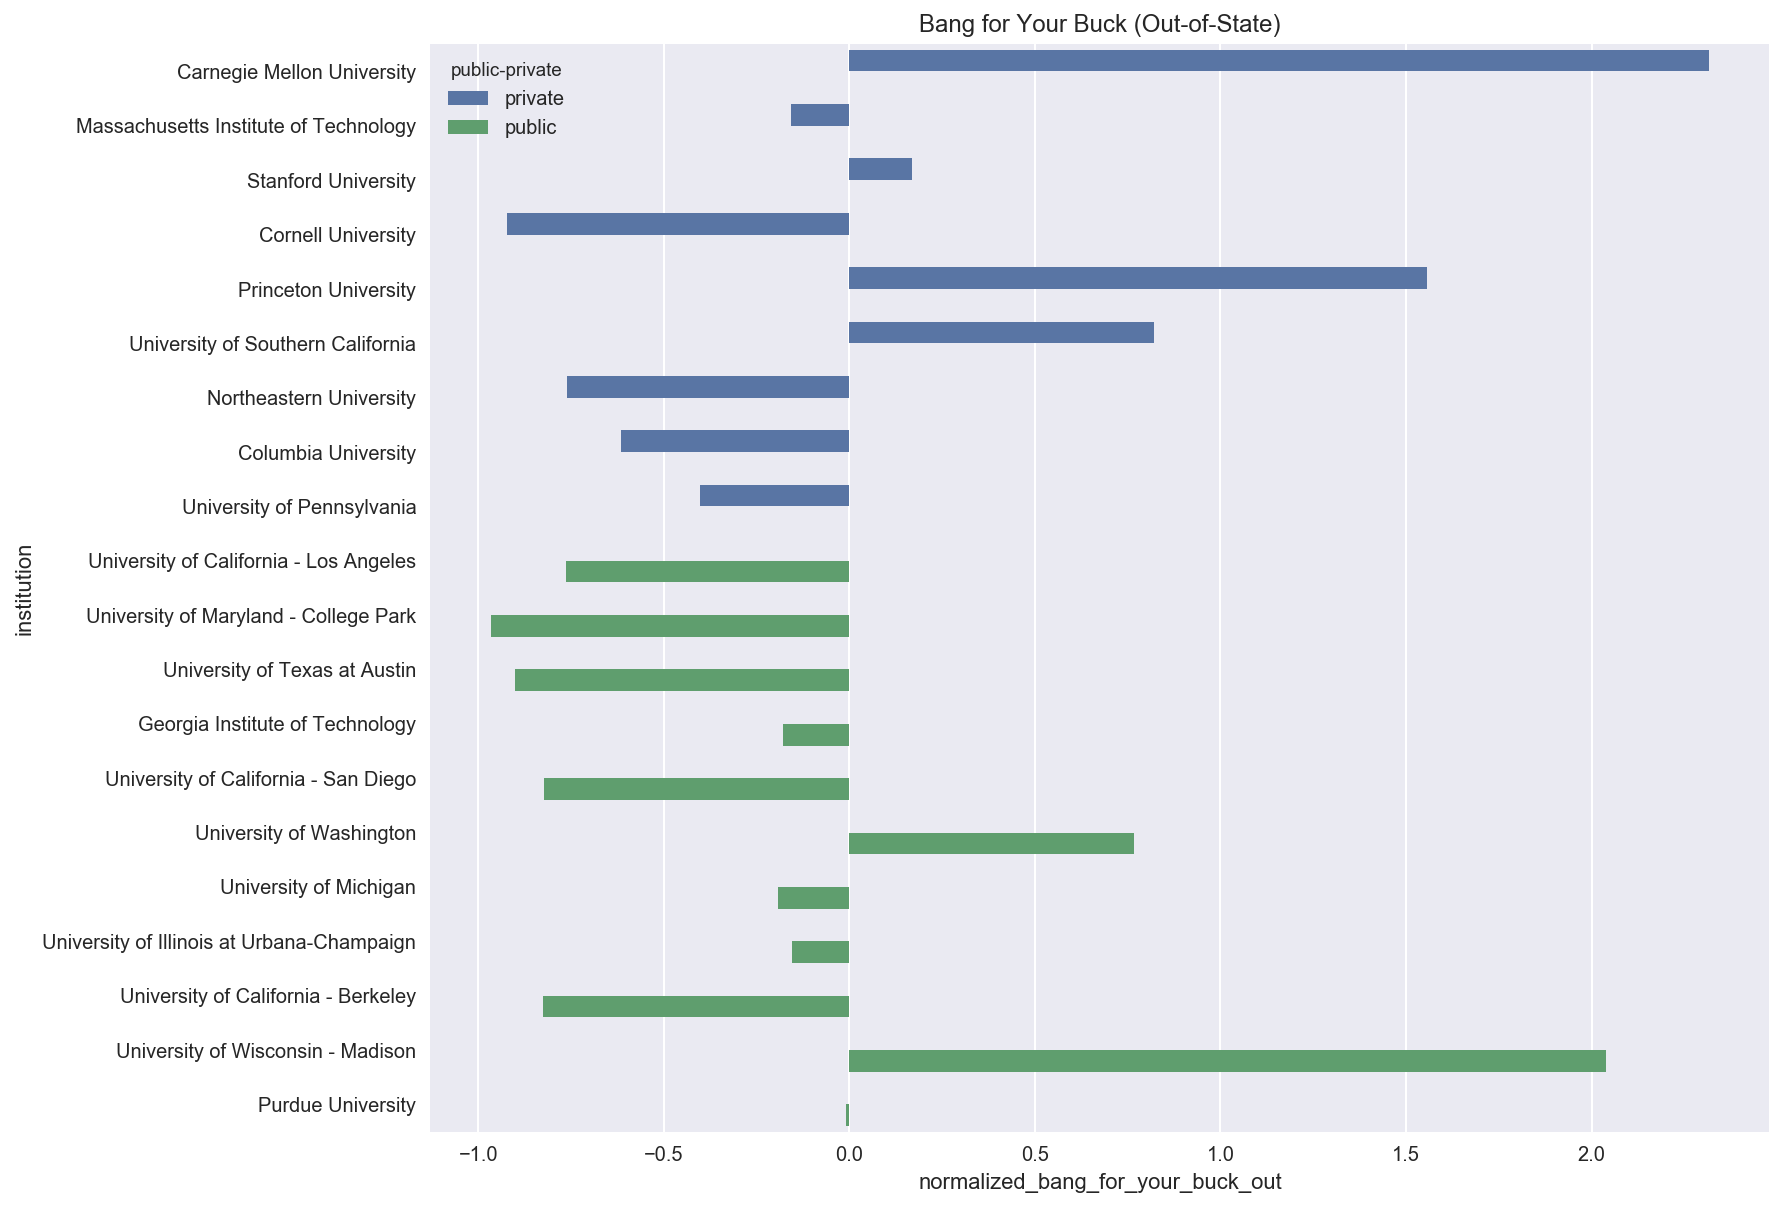

In [31]:
# plotting bang for your buck for out-of-state costs by institution
sns.barplot(y=top_20_sorted_private_public["institution"],
            x=top_20_sorted_private_public["normalized_bang_for_your_buck_out"],
            hue=top_20_sorted_private_public["public-private"])
plt.title("Bang for Your Buck (Out-of-State)")

Now, keeping private school tuitions constant, we're going to compare them to public universities' in-state tuitions.

Text(0.5,1,'Bang for Your Buck (In-State)')

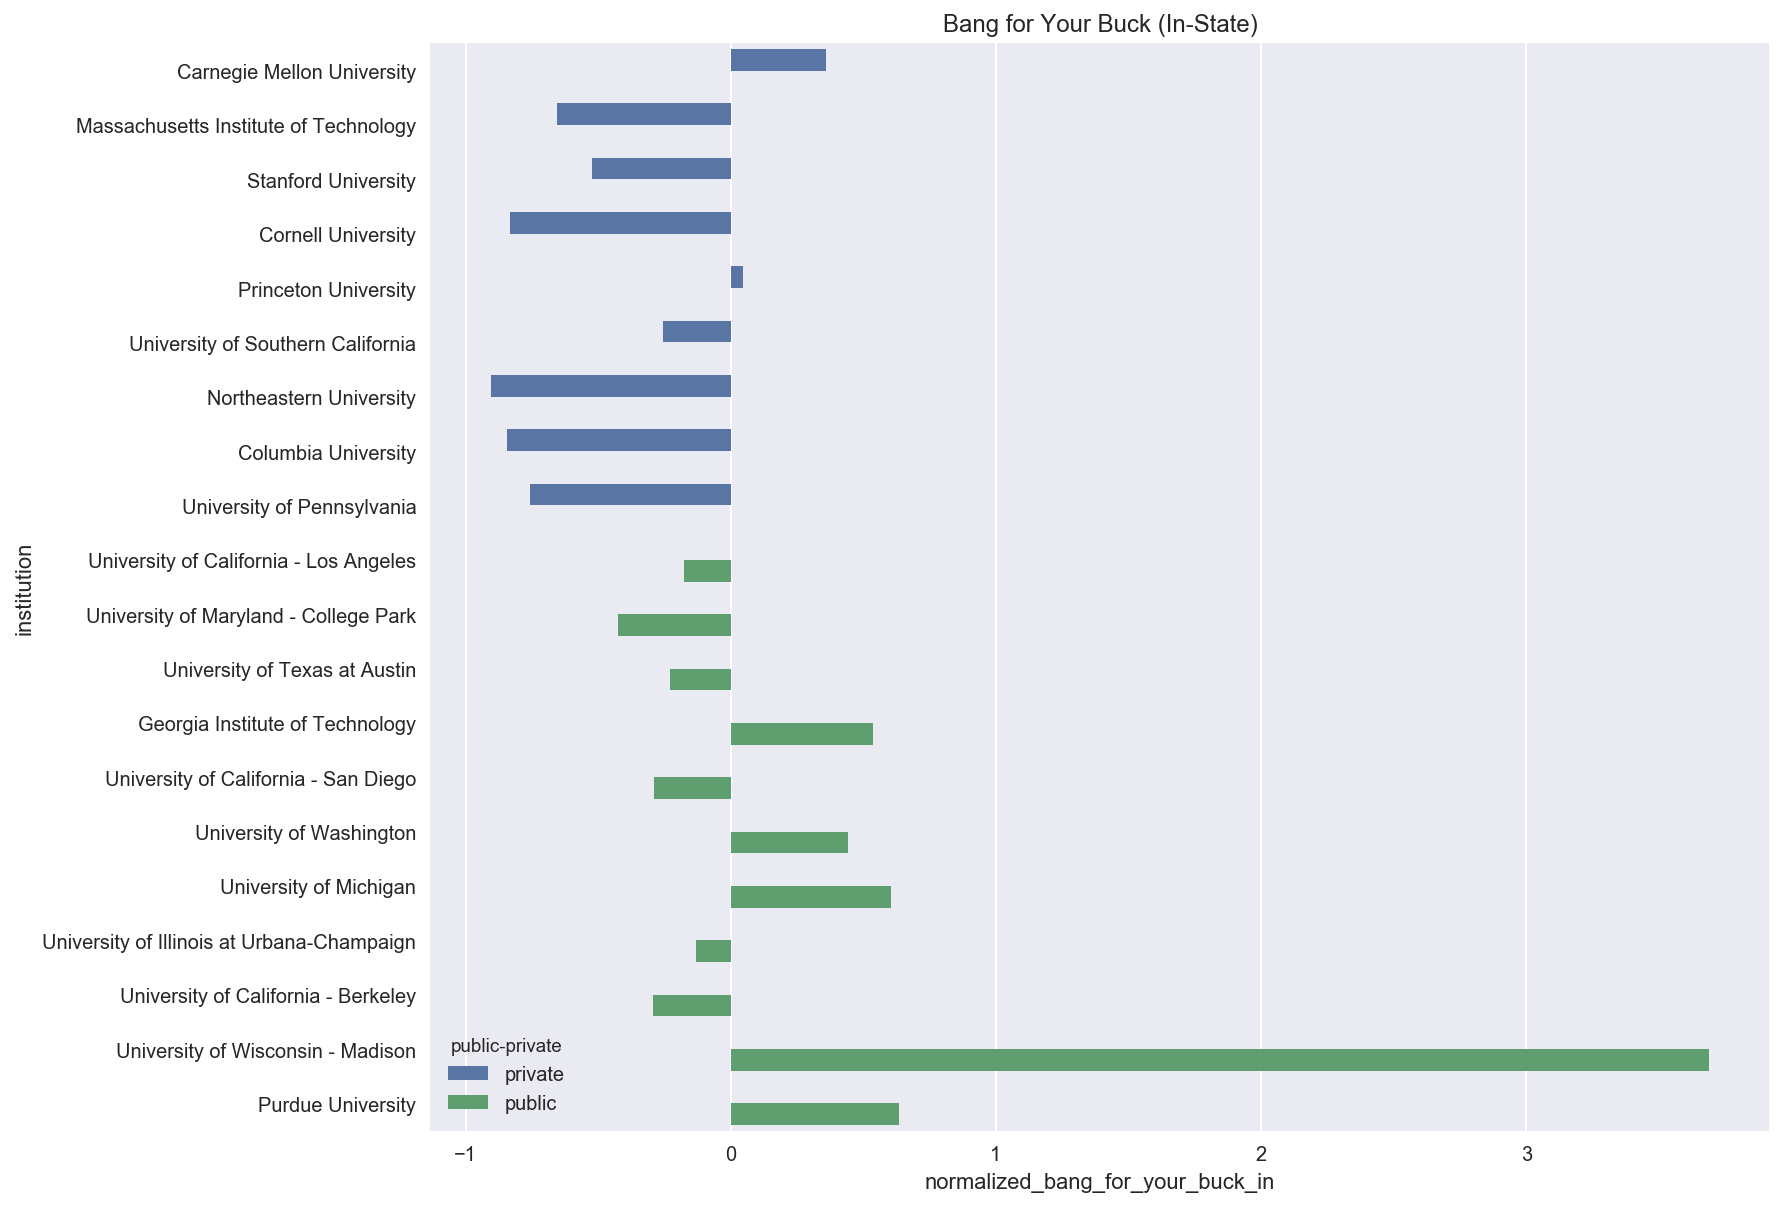

In [32]:
# plotting bang for your buck for in-state costs by institution
sns.barplot(y=top_20_sorted_private_public["institution"],
            x=top_20_sorted_private_public["normalized_bang_for_your_buck_in"],
            hue=top_20_sorted_private_public["public-private"])
plt.title("Bang for Your Buck (In-State)")

As expected, the private schools fared worse in this comparison. Also, way to go Wisconson.

On the other hand, it's not looking so great for UMD. It's the worst among all schools for out of state tuition. Even for in state tuition, UMD has the worst bang-for-buck among public universities. UMD is doing better than a few of the private schools, but not by much.

## 3.D How does this affect ranking?

We wanted to see how the factors we looked at affect rankings (since we know every school cares, as most people looking for schools care), so we're going to plot US News rankings against our bang-for-your-buck score and student/faculty ratio. Our null hypothesis is that there is no correlation between these factors and ranking. The alternative is that there is a correlation which is significantly different from zero. 

Unfortunately, Northeastern didn't make it into US New's ranking of global CS universities. That means we have a NaN value for their rank, which can't be plotted. So we will make a new table and drop Northeastern.

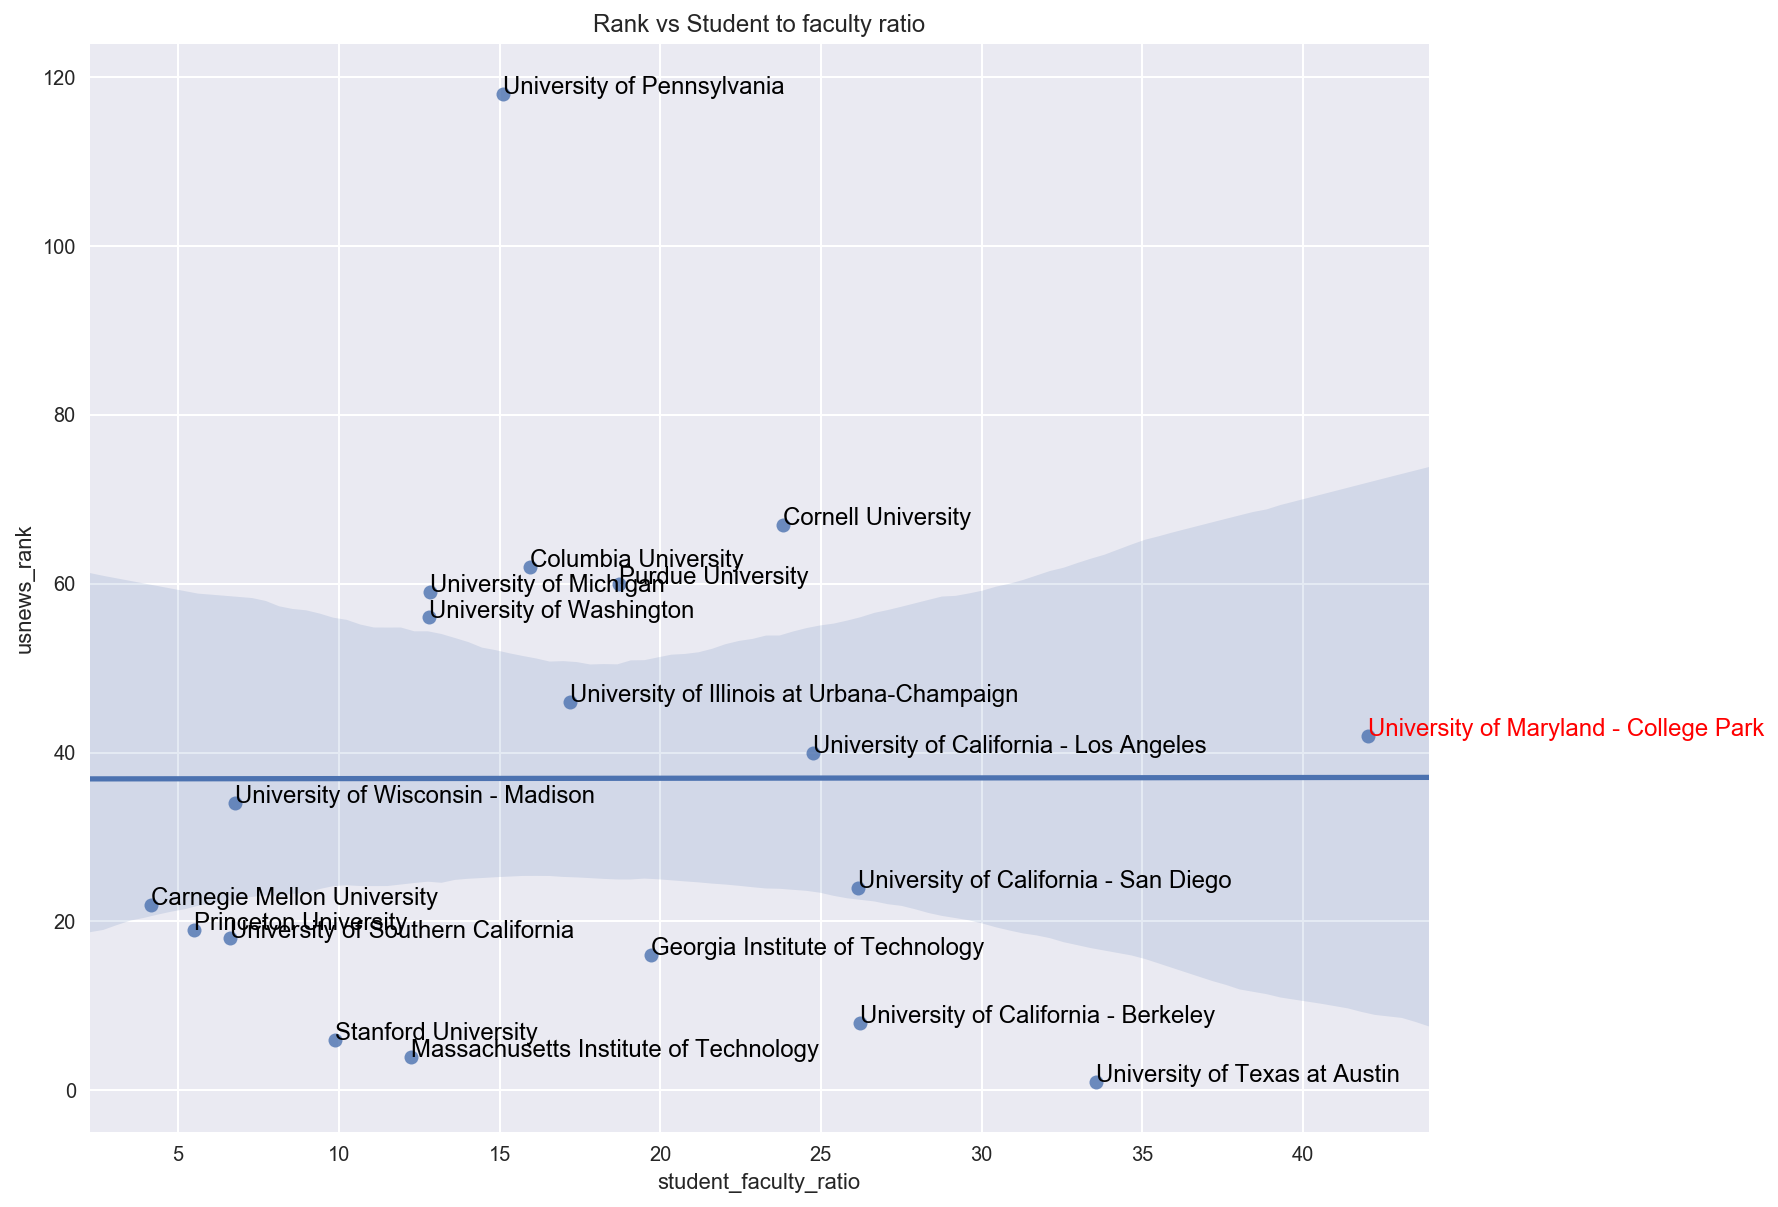

In [33]:
sorry_ne = top_20[["institution", "student_faculty_ratio", "usnews_rank", \
                   "normalized_bang_for_your_buck_out"]].copy()
sorry_ne.dropna(inplace=True)
sorry_ne.reset_index(inplace=True)
#plotting rank vs student to faculty ratio
regplot_top20(sorry_ne, "student_faculty_ratio", "usnews_rank",
              "Rank vs Student to faculty ratio")
# here, being in the bottom left corner is best. Then you're high rank and low student-faculty ratio

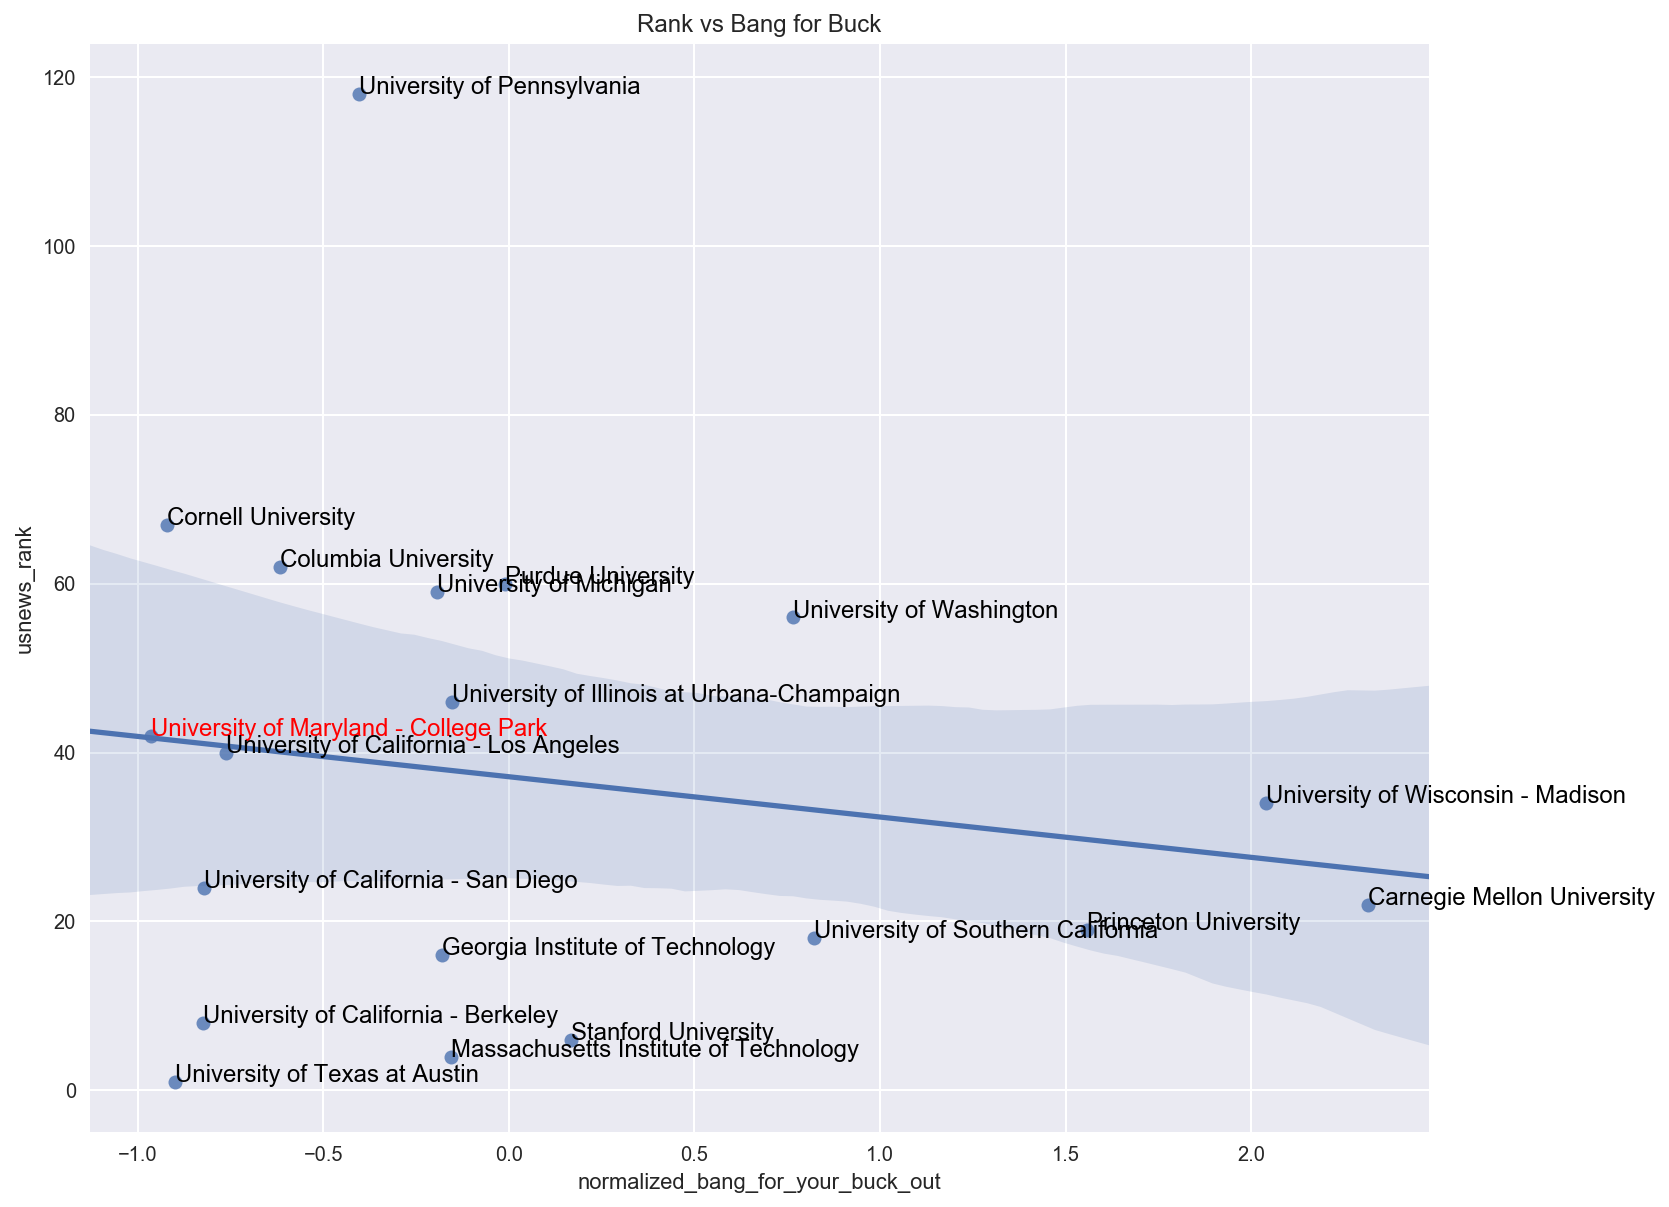

In [34]:
# plotting US News rank vs Bang for Buck
regplot_top20(sorry_ne, "normalized_bang_for_your_buck_out", "usnews_rank",
              "Rank vs Bang for Buck")
# here, being in the bottom right corner is best. You want a better ranking and a better bang for buck

Let's check the pearson's R and the corresponding p-value for student to faculty ratio and bang for buck.

In [35]:
from scipy.stats import pearsonr

pearsons_r, p_value = pearsonr(sorry_ne['student_faculty_ratio'], sorry_ne['usnews_rank'])
print("Pearson's r value for rank vs student to faculty ratio: {}".format(pearsons_r))
print("p-value for rank vs student to faculty ratio: {}\n".format(p_value))

pearsons_r, p_value = pearsonr(sorry_ne['normalized_bang_for_your_buck_out'], sorry_ne['usnews_rank'])
print("Pearson's r value for rank vs bang for buck: {}".format(pearsons_r))
print("p-value for rank vs bang for buck: {}".format(p_value))

Pearson's r value for rank vs student to faculty ratio: 0.001462662354511048
p-value for rank vs student to faculty ratio: 0.9952584179765831

Pearson's r value for rank vs bang for buck: -0.16554064553734263
p-value for rank vs bang for buck: 0.49822544549891135


Our p-values of 0.80 and 0.77 indicate that there is a high probability that we would see correlations as extreme as the r values found if the data was actually uncorrelated. As such, we can't reject either null hypothesis of no correlation between rank and the two metrics. Thus, those metrics likely have less to do with ranking than others.

## 3.E UMD Computer Science Growth Rate

Student population data pulled from: https://public.tableau.com/shared/RJ346YP5Z?:display_count=no 
Tuition data pulled from: http://otcads.umd.edu/bfa/budgetinfo3.htm

We manually collected the data into another csv, as there were only 12 entries to enter and we couldn't download it off tableau.

In [36]:
growth = pd.read_csv('UMD_populaton_intime.csv')
growth

,year,students,in_state_tuition,out_of_state_tuiton
0,Fall 2006,642,7821,20145
1,Fall 2007,692,6566,20005
2,Fall 2008,695,7969,22208
3,Fall 2009,796,8005,23076
4,Fall 2010,925,8053,23989
5,Fall 2011,1081,8416,24831
6,Fall 2012,1182,8655,26026
7,Fall 2013,1384,8908,27287
8,Fall 2014,1775,9161,28347
9,Fall 2015,2254,9427,29720


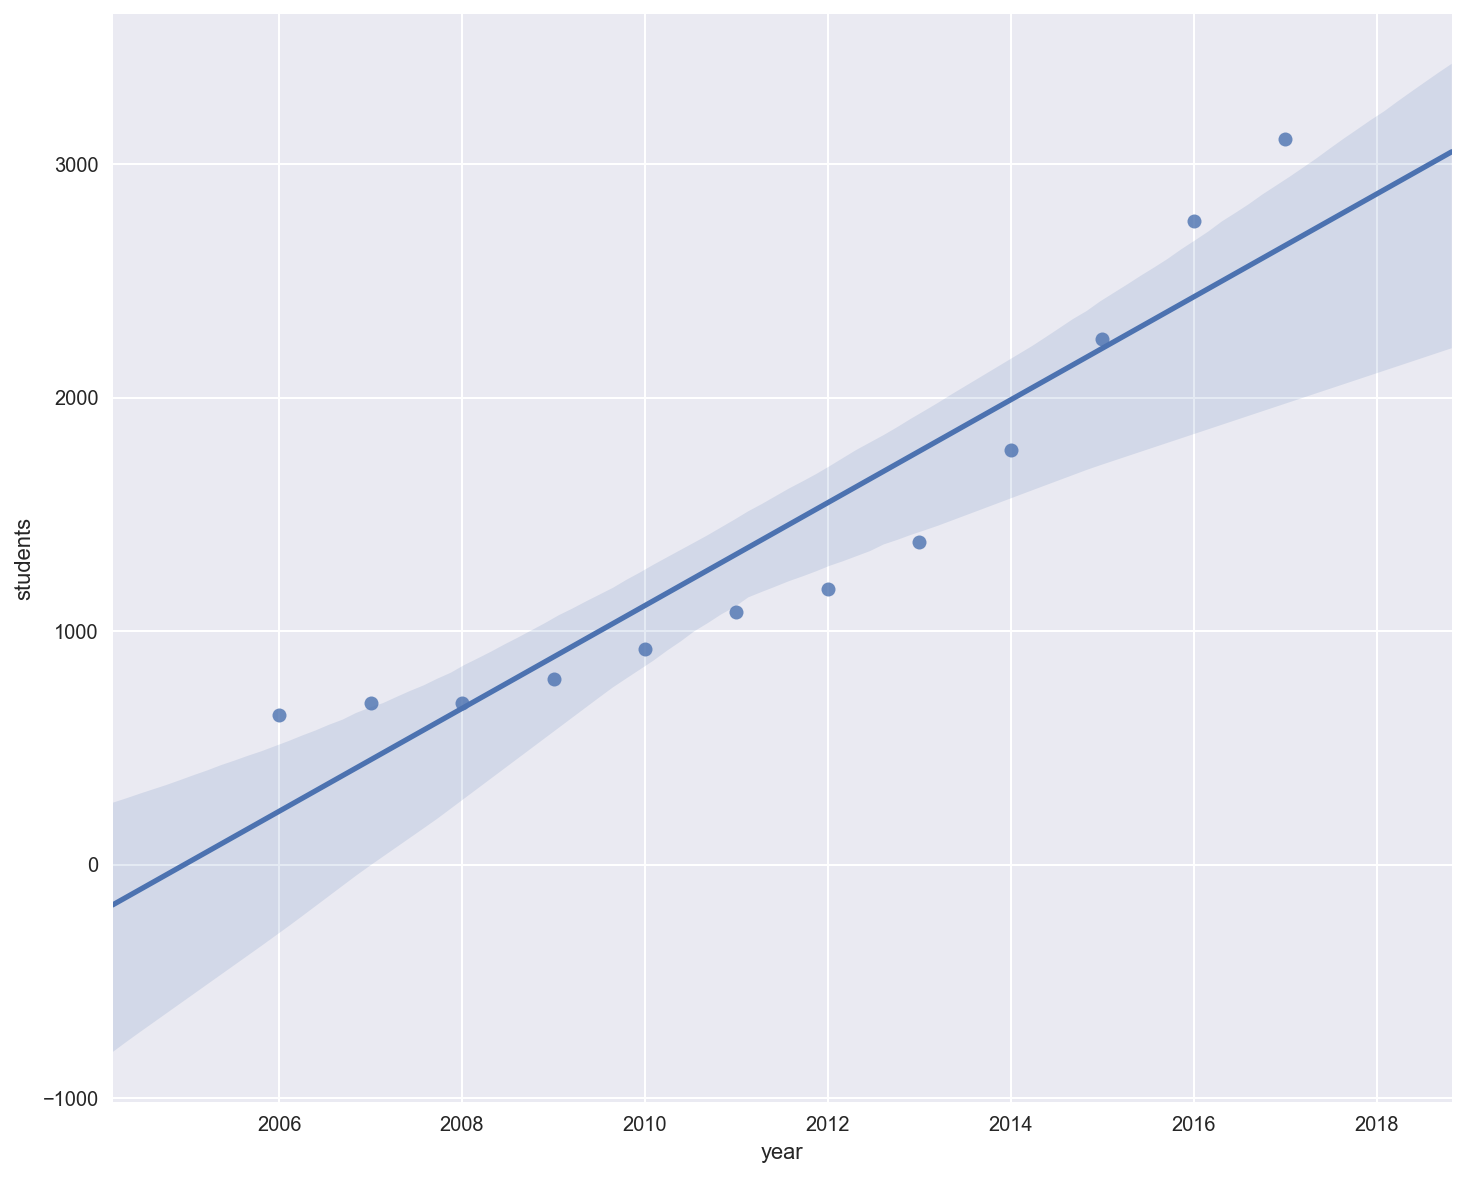

In [37]:
# removing the word "fall" from the year column so we can use it as a numerical value
growth['year'] = growth['year'].apply(lambda x: int(x[4:]))
sns.regplot(y=growth["students"], x=growth["year"])

It appears UMD CS has been growing quickly. Although the linear line seems to fit the data moderately well, it looks like the rate of growth is accelerating. We're going to try a polynomial fit and see how well that fits the data. This model may give an overestimation of future growth, but it should give us a general idea of where UMD is heading.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = growth[['year']]
# normalizing the data by counting years since 2006
X = X-2006
y = growth['students']

poly = PolynomialFeatures(degree=2)
# here, we're changing the 1 feature that we have of x = years since 2006 into an array of 1+x+x^2
# so that we can fit a quadratic function to the data
poly_X = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(poly_X,y)
# let's try predicting the number of students in the year 2018 = 2006+12
print("Expected number of students in 2018: {}".format(float(poly_model.predict([[1, 12, 12**2]]))))

Expected number of students in 2018: 3673.522727272727


Not a good sign, if this model is accurate. The CS department already has an issue with student-faculty ratio, and it looks like the student body is expected to grow even larger. Let's see how accurate this model is by plotting its predictions for the years 2006 to 2021, as well as the actual data points we have.

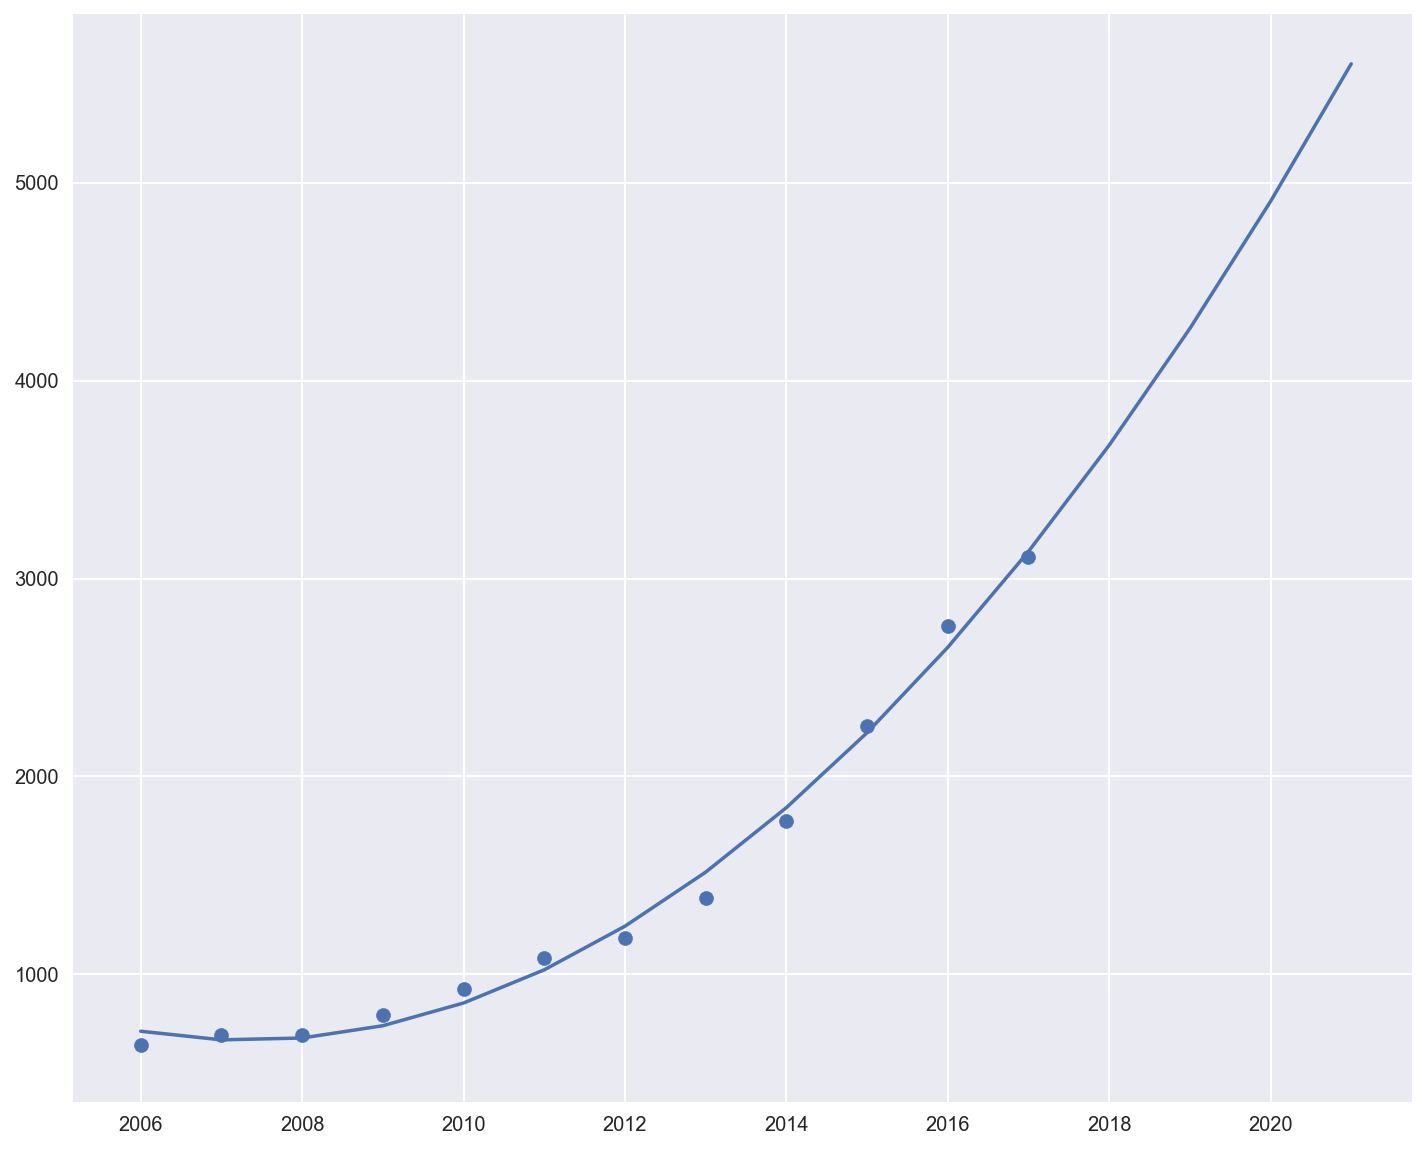

In [39]:
coefs = poly_model.coef_
years = np.linspace(0, 15, 16).reshape(-1, 1)
poly_years = poly.fit_transform(years)
years = years+2006
predictions = poly_model.predict(poly_years)

plt.plot(years, predictions)
plt.scatter(y=growth["students"], x=growth["year"])

It looks the the curve fits the data very well. UMD's CS population is projected to keep growing, and it looks like it's going to grow quickly as well.

## 3.F What does UMD need to do to keep up?

We have learned from our analysis that UMD is above the average in terms of student-faculty ratio. Now that we have a model that we can use to predict UMD's growth rate, we can find out what it needs to do to keep up with the average student-faculty ratio of other top 20 schools. 

First let's calculate that average for the other schools.

In [40]:
# only grabbing rows where the institution isn't called College Park
top_20_no_umd = top_20[top_20["institution"] != "University of Maryland - College Park"].copy()
# calculating and printing the mean student to faculty ratio
mean_sf_ratio = top_20_no_umd["student_faculty_ratio"].mean()
umd_sf_ratio = top_20[top_20["institution"] == "University of Maryland - College Park"]["student_faculty_ratio"]

print("Mean student-faculty ratio for other schools: {}".format(mean_sf_ratio))
print("Student-faculty ratio for UMD: {}".format(float(umd_sf_ratio)))

Mean student-faculty ratio for other schools: 16.47516421426746
Student-faculty ratio for UMD: 42.013513513513516


Okay, so it looks like there are about 17 professors per student on average at other universities. Whereas UMD has about 57.5. Let's calculate how many professors we need to hire to meet thw average ratio.

In [41]:
umd_faculty = top_20[top_20["institution"] == "University of Maryland - College Park"]["faculty_count"]
umd_students = top_20[top_20["institution"] == "University of Maryland - College Park"]["undergraduate_pop"]
# we want to find how many professors we'll need to hire, x, to meet the mean. 
# So we're solving the simple equation 16.95 = umd_students/(umd_faculty + x) for x
need_to_hire = (1/mean_sf_ratio)*(umd_students - mean_sf_ratio*umd_faculty)
print("""UMD needs to hire {} tenure track professors to have {} 
students per professor, the average for other universities.""".format(float(need_to_hire), mean_sf_ratio))

UMD needs to hire 114.70828597311414 tenure track professors to have 16.47516421426746 
students per professor, the average for other universities.


Now that just does not seem feasible. What if we only consider public schools and try again?

In [42]:
top_20_public = top_20_no_umd[top_20_no_umd["public-private"] == "public"]
mean_pub_ratio = top_20_public["student_faculty_ratio"].mean()
print("Mean student-faculty ratio for other public schools: {}\n".format(mean_pub_ratio))
need_to_hire = (1/mean_pub_ratio)*(umd_students - mean_pub_ratio*umd_faculty)
print("""UMD needs to hire {} tenure track professors to have {} 
students per professor, the average for other public universities.""".format(float(need_to_hire), mean_pub_ratio))

Mean student-faculty ratio for other public schools: 19.86961551835041

UMD needs to hire 82.47006340554049 tenure track professors to have 19.86961551835041 
students per professor, the average for other public universities.


A little more attainable. And that's how many professors are needed just to match up with the average right now. What if UMD grows even larger? I don't think UMD can possibly match up with the average anytime soon, but how about a goal? The mean is about 22 for public schools right now. Let's predict how many students UMD will have in 2020 and see how many professors UMD needs to reach a student-faculty ratio of 35 (what UT Austin currently has, the second highest overall student-faculty ratio of our top 20).

In [43]:
# 2020 is 14 years past 2006, so we'll use 14 as our x
umd_students_2020 = poly_model.predict([[1, 14, 14**2]])
# note that this is probably an overestimation. Hopefully growth will be reigned in somehow by 2020
# but based on current trends, if nothing changes, this looks to be a pretty accurate prediction
need_to_hire = float((1/35)*(umd_students - 35*umd_faculty))
need_to_hire_growth = float((1/35)*(umd_students_2020 - 35*umd_faculty))
print("How many professors should be hired if UMD CS doesn't grow at all until 2020: {}"
      .format(need_to_hire))
print("How many professors should be hired if UMD CS grows as predicted in 2020: {}"
      .format(need_to_hire_growth))


How many professors should be hired if UMD CS doesn't grow at all until 2020: 14.828571428571427
How many professors should be hired if UMD CS grows as predicted in 2020: 66.16120308263164


# 4. Conclusion

That is way more doable (If UMD CS does't grow at all)! UMD needs a NET GROWTH of 35 professors over the next 2 years in order to have a student faculty ratio that is on par with our next closest "competitor" for highest student-faculty ratio (If UMD CS does't grow at all). This seems like a pretty reasonable goal to attain, and a reasonable way to get there (If UMD CS does't grow at all).

Let's be honest. The size of the CS student population is probably going to grow. And if UMD wants to meet the goal of becoming a top 10 CS school by 2025, it needs to do much better than it's doing now. The department has to grow to meet the demands of a growing student body. The school clearly needs to hire more professors for the largest department on campus. 

Seeing these numbers, it's amazing that the professors here have been able to provide as good of an education as they have, considering how many more students each professor has to teach. Our upper level classes are becoming too large, and it's unfair to both the professors and students who deserve more personal interactions with their student body and faculty.

This story should serve as a warning to address problems before they grow too large, or else they may become too big to handle.

All csv files used can be found at: https://github.com/krixly/krixly.github.io